# trace_retrace.ipynb
## Training ML Models Using Trace and Retrace Data

This notebook should succeed in improving the ML models we have tested in `benchmark.ipynb` and `simulator.ipynb` by adding both **trace and retrace** data to the dataset fed into the ML algorithms.

Some pickle files have been added to the repo in addition to this notebook. The pickle files contain this information (in addition to `.ibw` filedata):
- __traces:__ shape of (N, M, C, L), forward and backward scan lines for the "Height", "Amplitude", "Phase", and "ZHeight" channels.
- __x_measured:__ shape of (N, D), controlling parameters of "drive", "setpoint", and "I gain" for each set of the traces. Both drive and setpoint are in the unit of nanometers.
- __y_measured:__ shape of (N, P), recorded reward values in the optimization process.
- __param:__ important global parameters for the dataset, including ['ScanSize', 'ScanRate', 'PointsLines', 'IntegralGain', 'InvOLS', 'SpringConstant', 'DriveFrequency']
- __header:__ all the global parameters recorded in the topo.ibw file by the SPM controller
- __topo:__ topography with the optimized parameters for visualizing the area where the traces were taken

***Explanation of the shape values:***
- __N:__ number of different sets of controlling parameters. This value corresponding to the length of x_measured and y_measured. The first 5-10 are usually the random seeding points.
- __M:__ number of repeats for each set of controlling parameters. Usually this value is set to 5 to avoid random errors in the scan lines.
- __C:__ number of different channels recorded for the traces, usually set to 8
- __L:__ number of pixels in each trace line, usually set to be 256
- __D:__ number of controlling parameters, usually set to be 3
- __P:__ number of rewards. For BO, it's 1. For MOBO, it can be 3-4

It is important to note that this information was taken from another notebook. Though there is talk about rewards for training for reinforcement learning (RL) or Bayesian optimization (BO), **this notebook will solely focus on using the data from these pickle files to detect failures in the SPM image.**




In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import aespm as ae

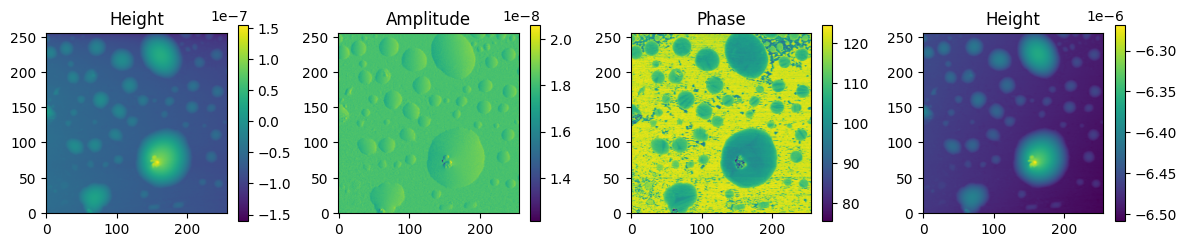

In [2]:
sample_folder = os.path.join('scan_traces', 'MOBO')

files = os.listdir(sample_folder)

file_name = []
save_name = []

for f in files:
    if f.endswith('.pickle'):
        file_name.append(os.path.join(sample_folder, f))
        save_name.append(f.split('.')[0])

file_name = sorted(file_name)
file_name

with open(file_name[-7], 'rb') as fopen:
    obj = pickle.load(fopen)

topo = obj['topo']
titles = ['Height', 'Amplitude', 'Phase', 'Height']
fig, ax = plt.subplots(1,4,figsize=[12, 2.5])
for i in range(4):
    # If there are only 4 data channels in the topo.data, we don't need to skip any index
    im = ax[i].imshow(topo.data[::2][i], origin='lower')
    ax[i].set_title(titles[i])
    plt.colorbar(im, ax=ax[i])

plt.tight_layout()

(60, 5, 8, 256)


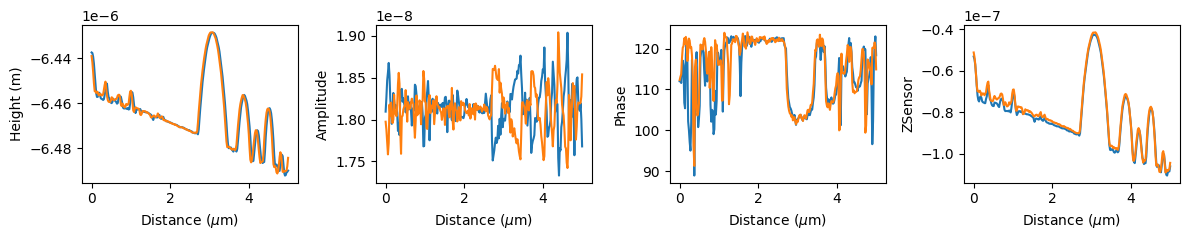

In [3]:
traces = obj['traces']
print(traces.data.shape)
np.shape(traces)

x = np.linspace(0, obj['param']['ScanSize']*1e6, np.shape(traces)[-1])

ylabels = ['Height (m)', 'Amplitude', 'Phase', 'ZSensor']
fig, ax = plt.subplots(1,4,figsize=[12, 2.5])
for i in range(4):
    ax[i].plot(x, traces[-1, -1, i*2], label='Fwd')
    ax[i].plot(x, traces[-1, -1, i*2+1], label='Bkd')
    ax[i].set_xlabel('Distance ($\mu$m)')
    ax[i].set_ylabel(ylabels[i])
    
plt.tight_layout()

# The forward scan is at the even index and the backward scan is at the odd index.

We now have a method to grab the trace and retrace information from these pickle files. So, to identify when there are errors in the SPM, we have several options.

Failures in the SPM typically arise from:
+ Non-overlapping trace/retrace curves in the Height, Phase, and ZSensor channels.
+ Distorted amplitude profiles.
+ Abnormally-high residuals between forward/backward paths.
+ Abrupt spikes or discontinuities in the lines.

So, similar to how we did for using the `.ibw` files, **we can use this data and some thresholds to create "good" and "bad" conditions.**

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trace_retrace(traces, scan_size_um, param_index=-1, repeat_index=-1, channel_names=None):
    """
    Plots forward (trace) and backward (retrace) scan lines for all channels.

    Parameters:
    - traces: np.ndarray, shape (N, M, C, L)
    - scan_size_um: float, total scan size in micrometers
    - param_index: int, index of which parameter set to show
    - repeat_index: int, index of which repeat to show
    - channel_names: list of str, optional names like ['Height', 'Amplitude', 'Phase', 'ZSensor']
    """
    if channel_names is None:
        channel_names = ['Channel {}'.format(i+1) for i in range(traces.shape[2] // 2)]

    x = np.linspace(0, scan_size_um, traces.shape[-1])
    n_channels = len(channel_names)

    fig, ax = plt.subplots(1, n_channels, figsize=(n_channels*4, 3))
    if n_channels == 1:
        ax = [ax]  # Make it iterable

    for i in range(n_channels):
        fwd = traces[param_index, repeat_index, i*2]
        bkd = traces[param_index, repeat_index, i*2 + 1]
        ax[i].plot(x, fwd, label='Trace', color='blue')
        ax[i].plot(x, bkd, label='Retrace', color='orange')
        ax[i].set_title(channel_names[i])
        ax[i].set_xlabel('Distance (μm)')
        ax[i].set_ylabel('Signal')
        ax[i].legend()

    plt.tight_layout()
    plt.show()

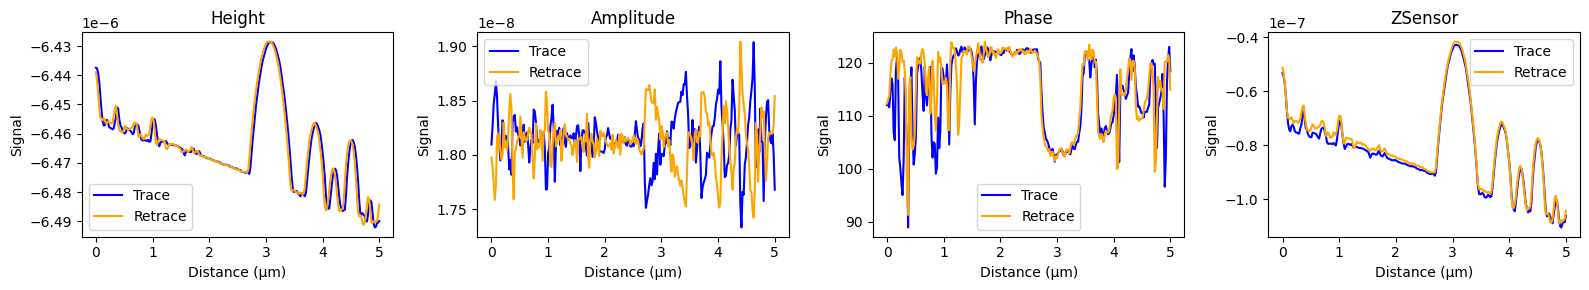

In [5]:
plot_trace_retrace(traces, scan_size_um=obj['param']['ScanSize']*1e6,
                   param_index=-1, repeat_index=-1,
                   channel_names=['Height', 'Amplitude', 'Phase', 'ZSensor'])

This allows us to plot the trace and retrace for visual identification of faults in the SPM. Next, we can use **mean absolute error (MAE) to see how different the trace/retraces are**.

In [6]:
def trace_retrace_score(traces, param_index, repeat_index, channel_names=None):
    """
    Returns simple similarity metrics for each channel.

    Returns a dict: {channel: {'mae': ..., 'corr': ...}, ...}
    """
    if channel_names is None:
        channel_names = ['Channel {}'.format(i+1) for i in range(traces.shape[2] // 2)]

    results = {}
    for i, name in enumerate(channel_names):
        fwd = traces[param_index, repeat_index, i*2]
        bkd = traces[param_index, repeat_index, i*2 + 1]

        mae = np.mean(np.abs(fwd - bkd))
        corr = np.corrcoef(fwd, bkd)[0, 1]

        results[name] = {'mae': mae, 'corr': corr}

    return results

In [7]:
trace_retrace_score(traces, param_index=-1, repeat_index=-1,
                    channel_names=['Height', 'Amplitude', 'Phase', 'ZSensor'])

{'Height': {'mae': np.float64(2.394587639287238e-09),
  'corr': np.float64(0.969860344277649)},
 'Amplitude': {'mae': np.float64(3.164682335632385e-10),
  'corr': np.float64(-0.8588460308973723)},
 'Phase': {'mae': np.float64(3.1953956186771393),
  'corr': np.float64(0.715178625557531)},
 'ZSensor': {'mae': np.float64(1.6094758581441937e-09),
  'corr': np.float64(0.9970957623678702)}}


=== File 1: 250205_RedSample2_BO.pickle ===
Height     | MAE: 1.486e-07 | Corr: +0.193
Amplitude  | MAE: 5.394e-09 | Corr: -0.408
Phase      | MAE: 1.599e+01 | Corr: +0.118
ZSensor    | MAE: 3.161e-08 | Corr: +0.975


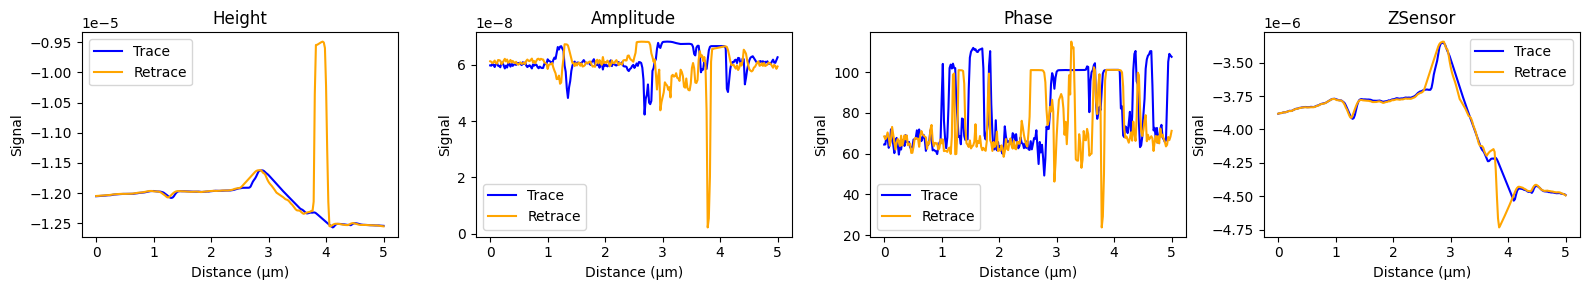


=== File 2: 250205_RedSample3_MOBO.pickle ===
Height     | MAE: 4.758e-08 | Corr: +0.978
Amplitude  | MAE: 7.140e-09 | Corr: -0.621
Phase      | MAE: 2.949e+01 | Corr: -0.147
ZSensor    | MAE: 3.676e-08 | Corr: +0.989


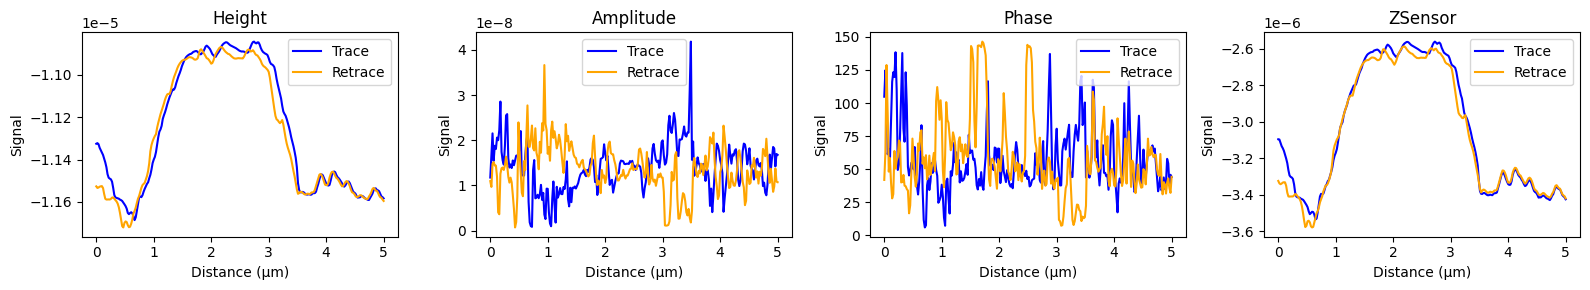


=== File 3: 250206_Red4_MOBO.pickle ===
Height     | MAE: 5.020e-09 | Corr: +0.999
Amplitude  | MAE: 1.113e-09 | Corr: -0.349
Phase      | MAE: 7.302e+00 | Corr: +0.874
ZSensor    | MAE: 1.871e-08 | Corr: +0.999


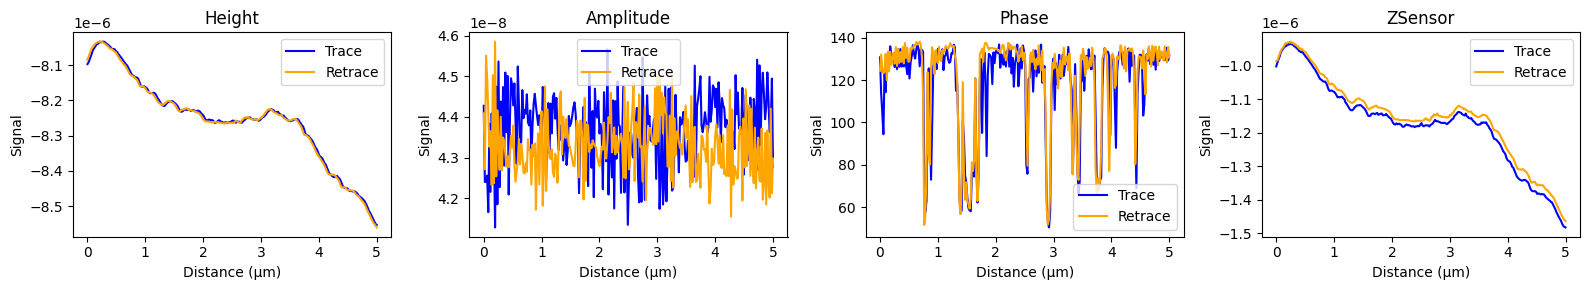


=== File 4: 250206_Red5_MOBO.pickle ===
Height     | MAE: 4.037e-09 | Corr: +0.960
Amplitude  | MAE: 9.188e-10 | Corr: -0.929
Phase      | MAE: 2.735e+00 | Corr: +0.093
ZSensor    | MAE: 1.706e-09 | Corr: +0.998


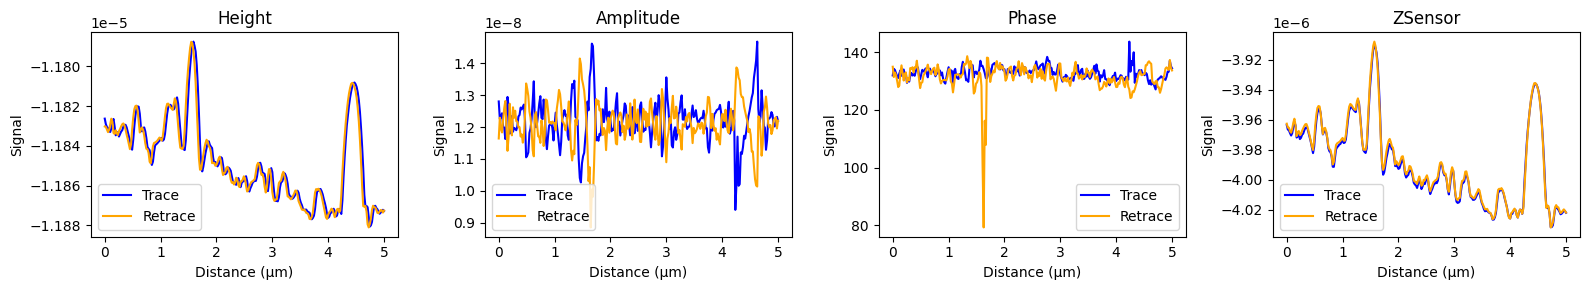


=== File 5: 250206_RedSample1_BO.pickle ===
Height     | MAE: 5.356e-08 | Corr: +0.991
Amplitude  | MAE: 7.664e-09 | Corr: -0.466
Phase      | MAE: 2.801e+01 | Corr: +0.563
ZSensor    | MAE: 9.921e-08 | Corr: +0.990


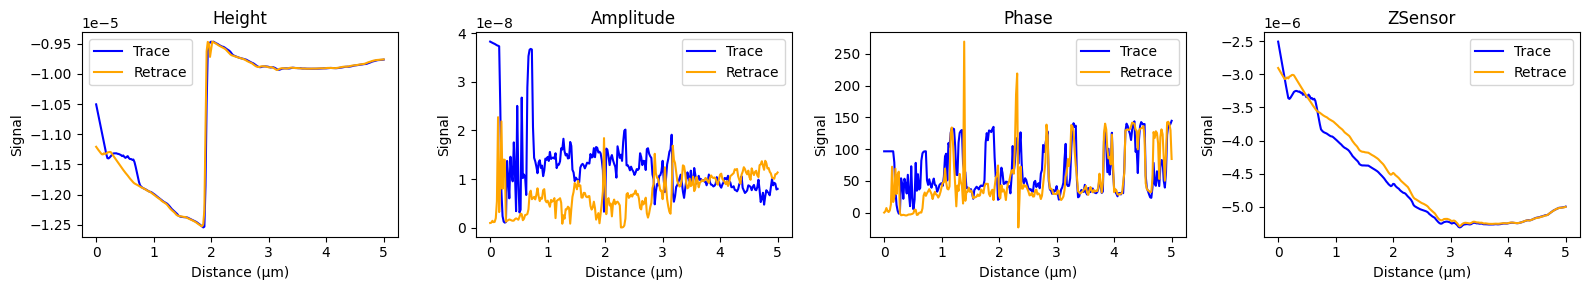


=== File 6: 250206_RedSample2_MOBO.pickle ===
Height     | MAE: 6.920e-08 | Corr: +0.985
Amplitude  | MAE: 7.375e-09 | Corr: -0.694
Phase      | MAE: 2.030e+01 | Corr: +0.226
ZSensor    | MAE: 3.929e-08 | Corr: +0.994


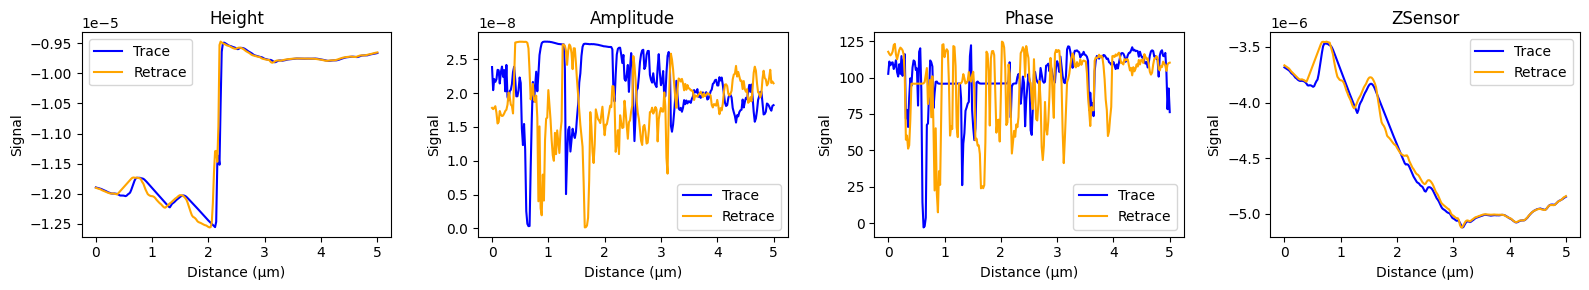


=== File 7: 250206_RedSample3_MOBO.pickle ===
Height     | MAE: 2.083e-08 | Corr: +0.989
Amplitude  | MAE: 1.568e-09 | Corr: -0.730
Phase      | MAE: 1.982e+01 | Corr: -0.111
ZSensor    | MAE: 4.445e-08 | Corr: +0.995


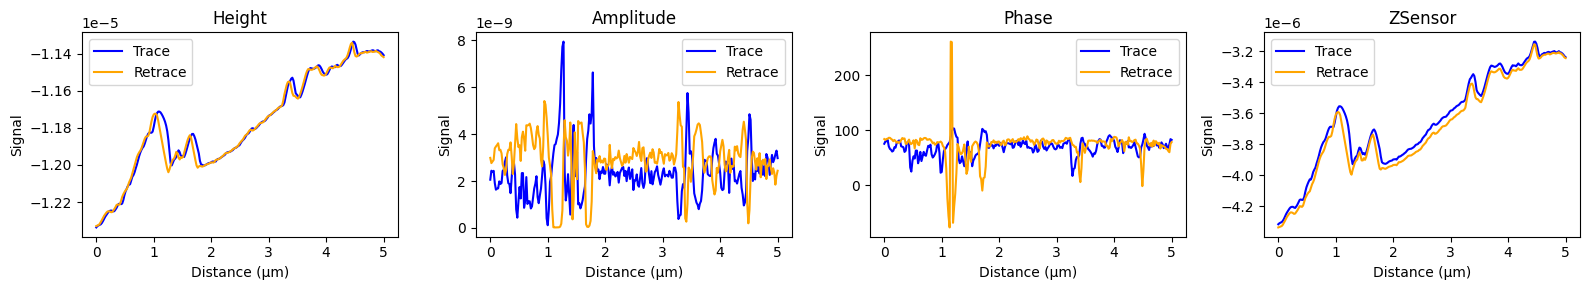


=== File 8: 250206_WTV1_MOBO.pickle ===
Height     | MAE: 7.102e-09 | Corr: +0.943
Amplitude  | MAE: 8.301e-10 | Corr: -0.183
Phase      | MAE: 9.031e+00 | Corr: +0.067
ZSensor    | MAE: 2.273e-09 | Corr: +0.995


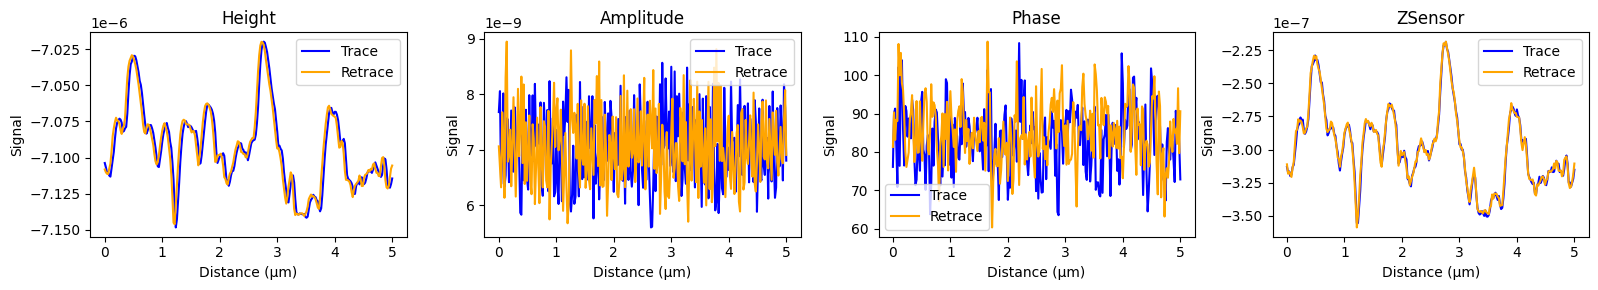


=== File 9: 250206_Yellow1_MOBO.pickle ===
Height     | MAE: 2.778e-09 | Corr: +0.992
Amplitude  | MAE: 7.970e-10 | Corr: -0.103
Phase      | MAE: 2.196e+00 | Corr: -0.136
ZSensor    | MAE: 2.466e-09 | Corr: +0.995


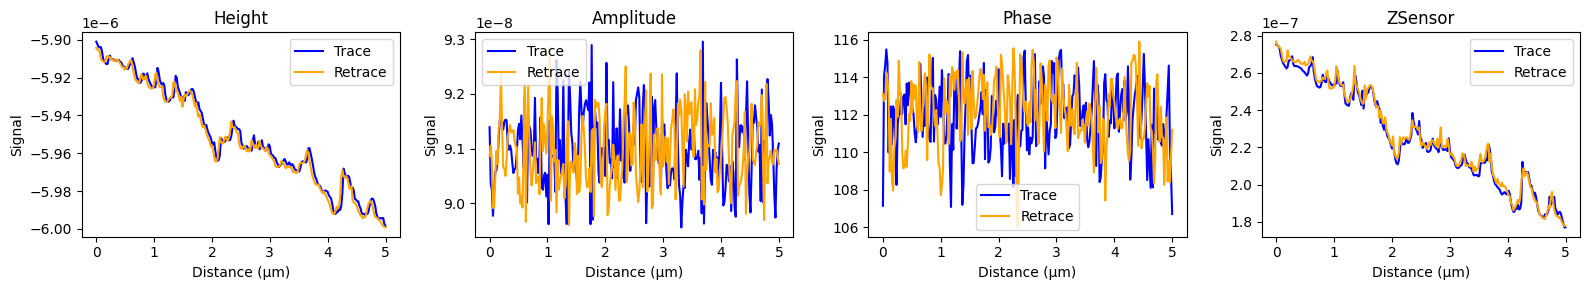


=== File 10: 250313_CaliSample_MOBO1.pickle ===
Height     | MAE: 3.255e-09 | Corr: +0.992
Amplitude  | MAE: 9.563e-10 | Corr: -0.731
Phase      | MAE: 2.006e+00 | Corr: +0.602
ZSensor    | MAE: 6.171e-09 | Corr: +0.995


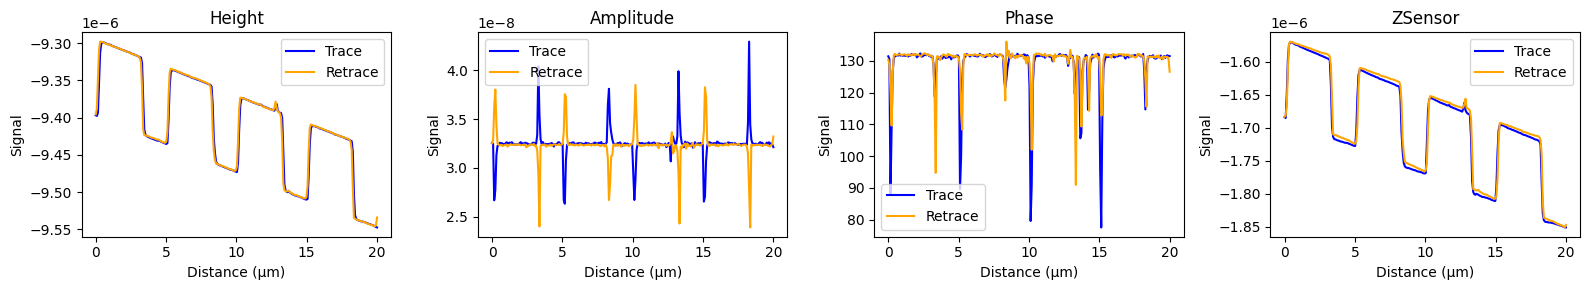


=== File 11: 250313_CaliSample_MOBO3.pickle ===
Height     | MAE: 2.657e-09 | Corr: +0.994
Amplitude  | MAE: 4.825e-10 | Corr: -0.762
Phase      | MAE: 4.123e+00 | Corr: +0.904
ZSensor    | MAE: 7.763e-09 | Corr: +0.986


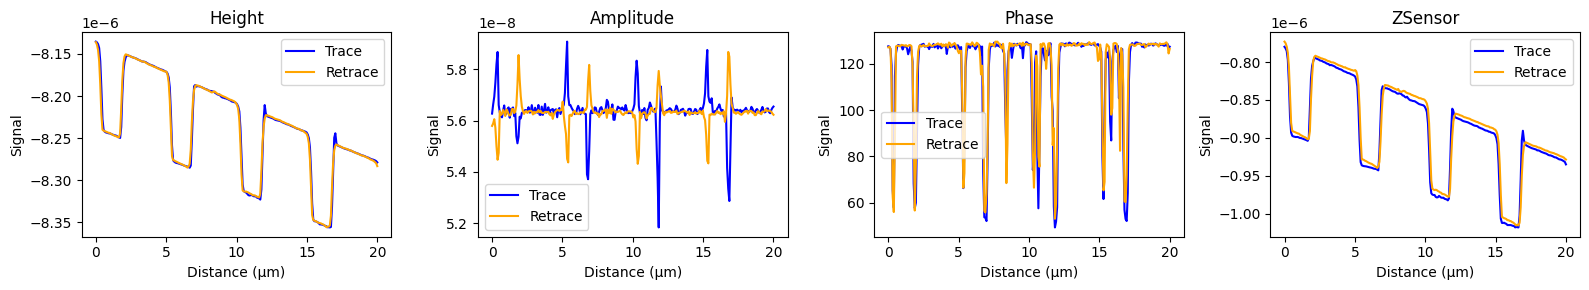


=== File 12: 250314_Droplet1_MOBO.pickle ===
Height     | MAE: 4.031e-09 | Corr: +0.958
Amplitude  | MAE: 4.777e-10 | Corr: -0.938
Phase      | MAE: 6.026e+00 | Corr: +0.400
ZSensor    | MAE: 1.467e-09 | Corr: +0.997


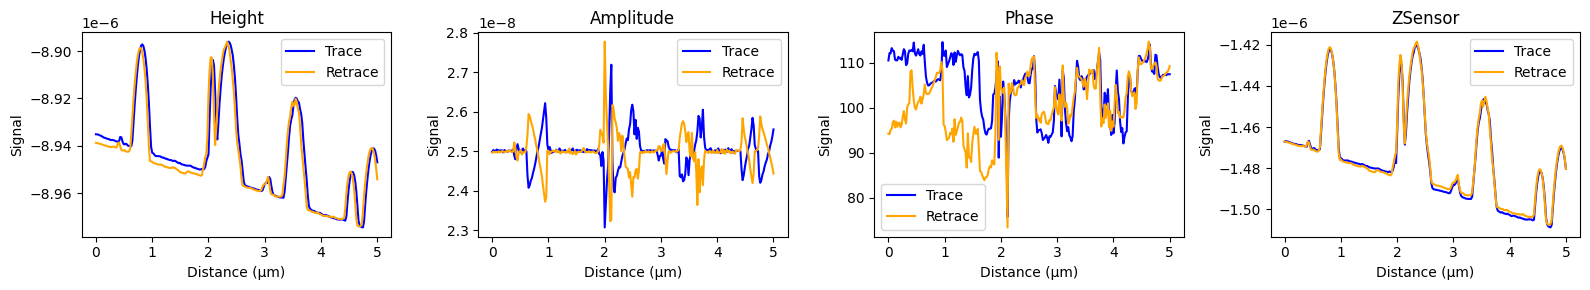


=== File 13: 250314_Droplet2_MOBO.pickle ===
Height     | MAE: 2.245e-09 | Corr: +0.970
Amplitude  | MAE: 2.790e-10 | Corr: -0.048
Phase      | MAE: 1.239e+00 | Corr: +0.842
ZSensor    | MAE: 2.702e-09 | Corr: +0.994


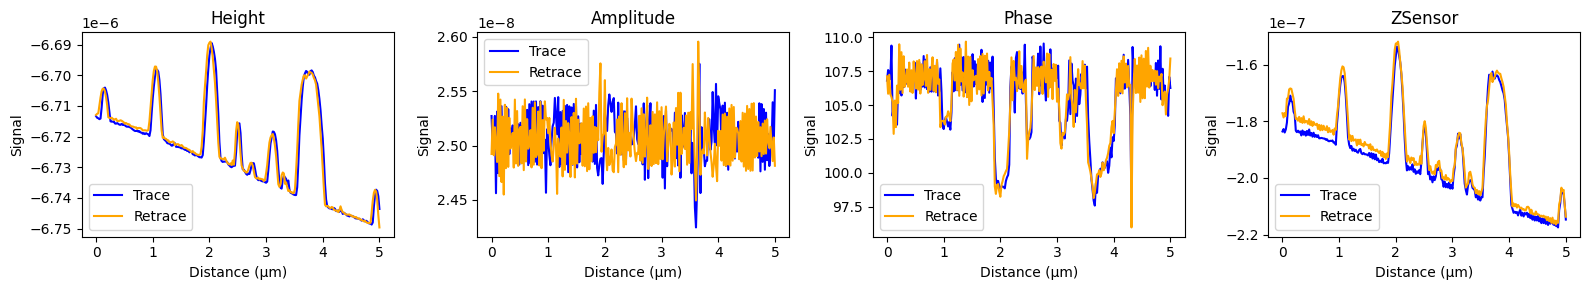


=== File 14: 250314_Droplet3_MOBO.pickle ===
Height     | MAE: 2.147e-09 | Corr: +0.980
Amplitude  | MAE: 2.788e-10 | Corr: -0.850
Phase      | MAE: 1.820e+00 | Corr: +0.877
ZSensor    | MAE: 1.591e-09 | Corr: +0.999


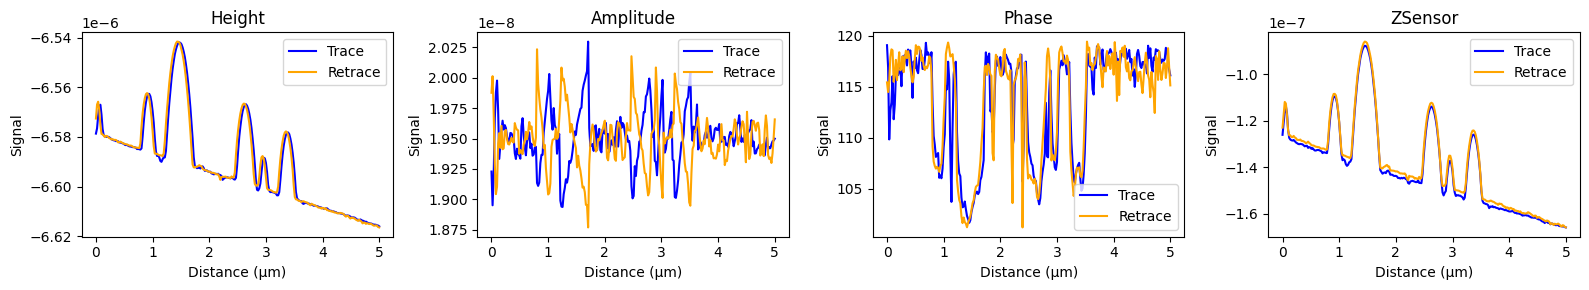


=== File 15: 250314_Droplet4_MOBO.pickle ===
Height     | MAE: 2.395e-09 | Corr: +0.970
Amplitude  | MAE: 3.165e-10 | Corr: -0.859
Phase      | MAE: 3.195e+00 | Corr: +0.715
ZSensor    | MAE: 1.609e-09 | Corr: +0.997


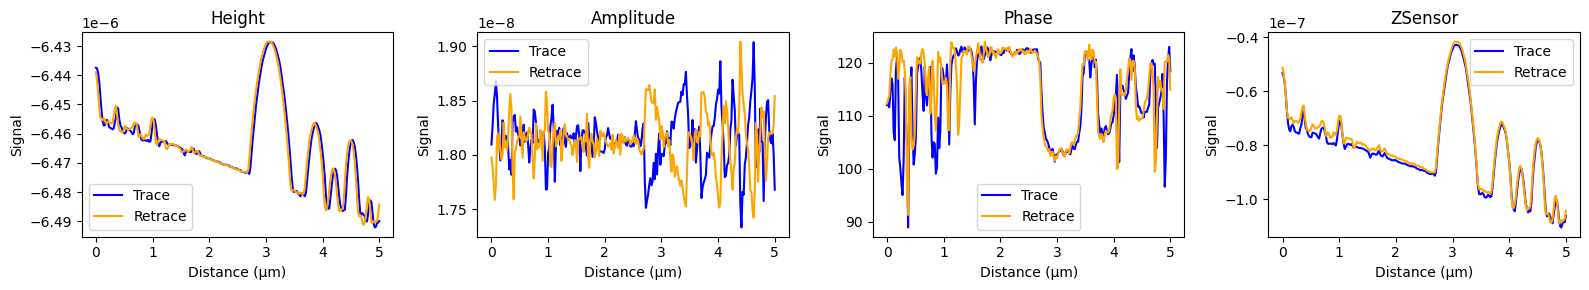


=== File 16: 250314_Droplet5_MOBO.pickle ===
Height     | MAE: 1.377e-09 | Corr: +0.982
Amplitude  | MAE: 2.367e-10 | Corr: -0.584
Phase      | MAE: 2.573e+00 | Corr: +0.628
ZSensor    | MAE: 1.622e-09 | Corr: +0.999


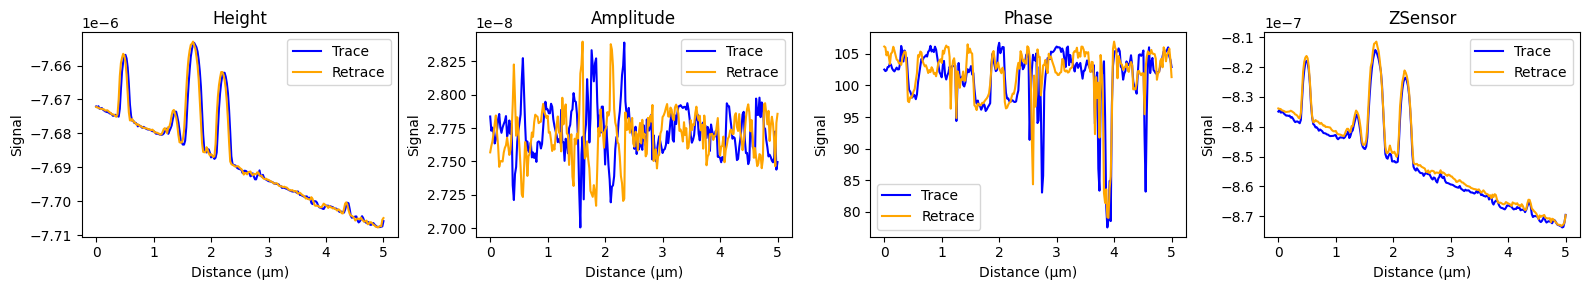


=== File 17: 250315_Cali1_MOBO.pickle ===
Height     | MAE: 3.704e-09 | Corr: +0.990
Amplitude  | MAE: 9.395e-10 | Corr: -0.540
Phase      | MAE: 6.581e+00 | Corr: +0.451
ZSensor    | MAE: 7.047e-09 | Corr: +0.988


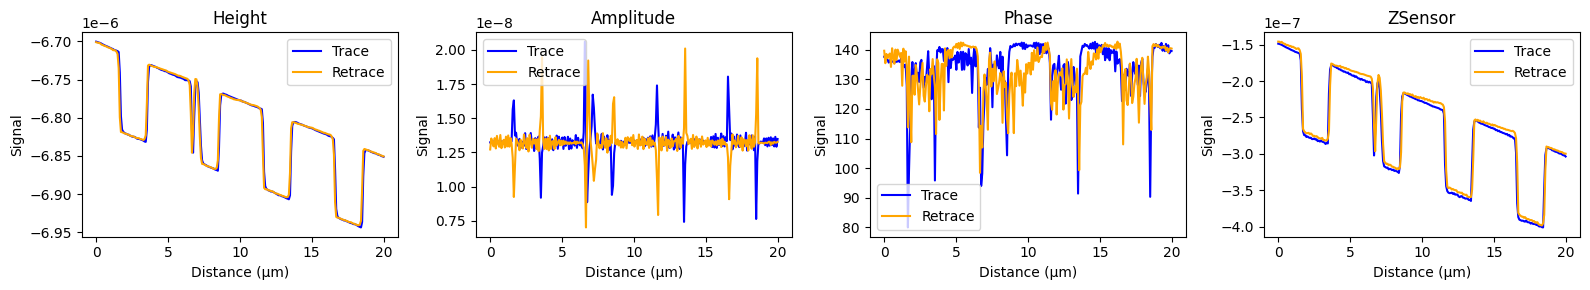


=== File 18: 250315_Red1_MOBO.pickle ===
Height     | MAE: 1.155e-08 | Corr: +0.986
Amplitude  | MAE: 2.147e-09 | Corr: +0.037
Phase      | MAE: 7.131e+00 | Corr: +0.027
ZSensor    | MAE: 1.851e-08 | Corr: +0.978


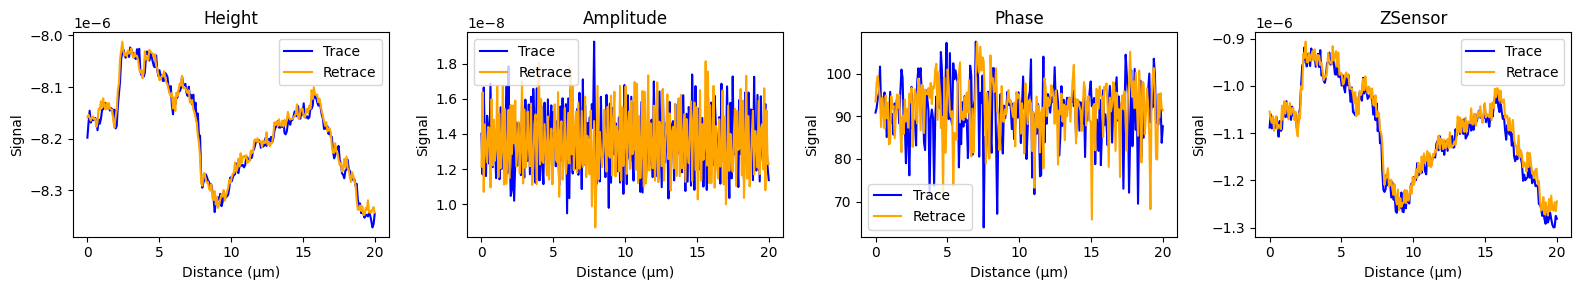


=== File 19: 250315_Red2_MOBO.pickle ===
Height     | MAE: 1.024e-08 | Corr: +0.989
Amplitude  | MAE: 8.524e-10 | Corr: -0.790
Phase      | MAE: 2.748e+00 | Corr: +0.090
ZSensor    | MAE: 8.669e-08 | Corr: +0.983


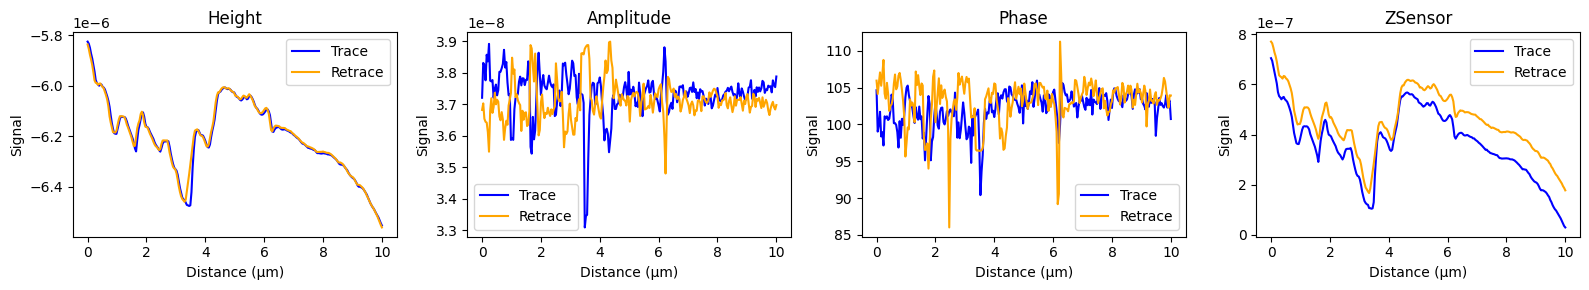


=== File 20: 250315_Red3_MOBO.pickle ===
Height     | MAE: 7.095e-09 | Corr: +0.995
Amplitude  | MAE: 1.041e-09 | Corr: -0.517
Phase      | MAE: 2.149e+00 | Corr: +0.813
ZSensor    | MAE: 1.256e-08 | Corr: +0.994


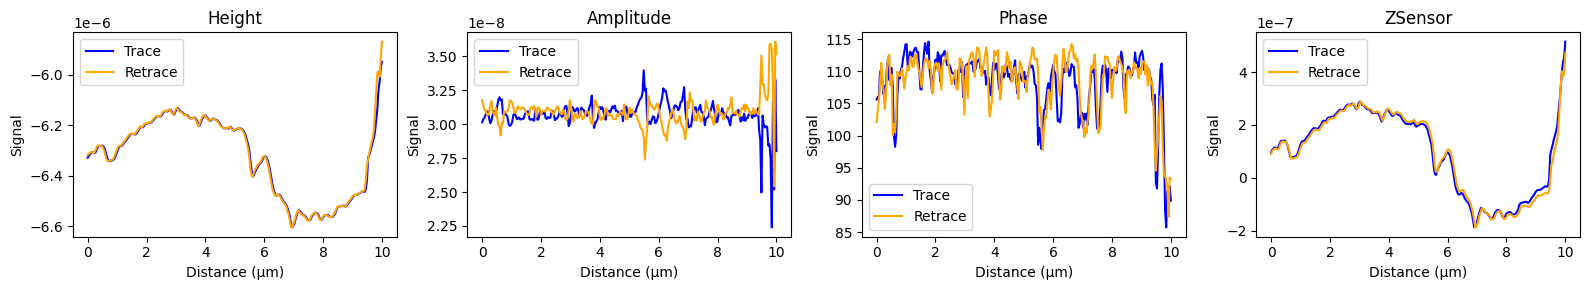


=== File 21: 250315_Yellow1_MOBO.pickle ===
Height     | MAE: 6.786e-08 | Corr: -0.684
Amplitude  | MAE: 6.797e-11 | Corr: +0.099
Phase      | MAE: 1.879e+00 | Corr: -0.015
ZSensor    | MAE: 6.755e-08 | Corr: -0.672


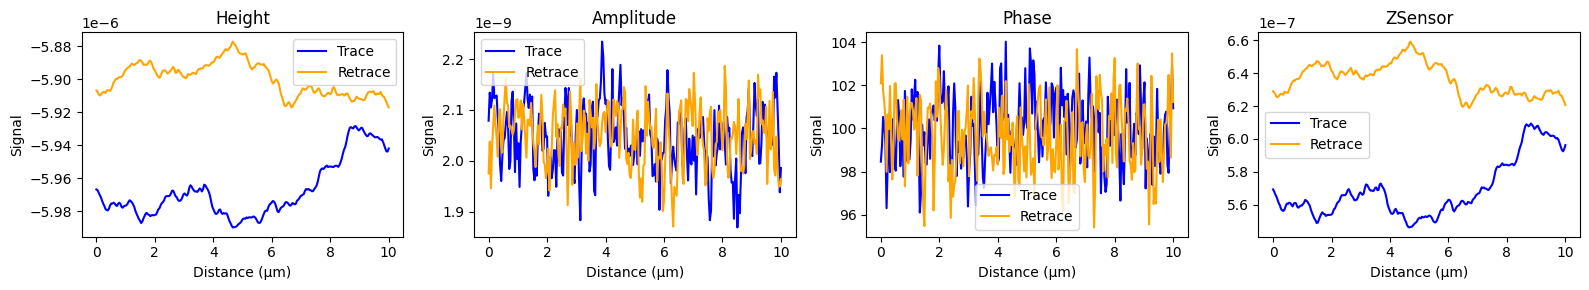

In [8]:
import os
import pickle
import numpy as np
from scipy.stats import pearsonr

# Set the folder path
sample_folder = os.path.join('scan_traces', 'MOBO')

# Get list of all .pickle files
files = sorted([
    os.path.join(sample_folder, f) for f in os.listdir(sample_folder)
    if f.endswith('.pickle')
])

# Helper function: Compute MAE and correlation between forward and backward traces
def compute_trace_metrics(trace_data):
    results = {}
    channel_names = ['Height', 'Amplitude', 'Phase', 'ZSensor']
    
    for i, name in enumerate(channel_names):
        fwd = trace_data[i * 2]
        bwd = trace_data[i * 2 + 1]
        
        mae = np.mean(np.abs(fwd - bwd))
        try:
            corr, _ = pearsonr(fwd, bwd)
        except:
            corr = np.nan
        
        results[name] = {'mae': mae, 'corr': corr}
    
    return results

# Loop through each file
for idx, fname in enumerate(files):
    with open(fname, 'rb') as fopen:
        obj = pickle.load(fopen)
    
    print(f"\n=== File {idx+1}: {os.path.basename(fname)} ===")
    
    traces = obj['traces']
    
    # Use the last scan: shape (N, M, C, L)
    trace_sample = traces[-1, -1]  # Shape (8, L), assumes 4 channels with forward/backward pairs
    
    metrics = compute_trace_metrics(trace_sample)
    
    for ch in metrics:
        mae = metrics[ch]['mae']
        corr = metrics[ch]['corr']
        print(f"{ch:10s} | MAE: {mae:.3e} | Corr: {corr:+.3f}")

    plot_trace_retrace(traces, scan_size_um=obj['param']['ScanSize']*1e6,
                   param_index=-1, repeat_index=-1,
                   channel_names=['Height', 'Amplitude', 'Phase', 'ZSensor'])

In [ ]:
import matplotlib.pyplot as plt

def plot_traces(forward_avg, backward_avg, filename):
    n_channels = forward_avg.shape[0]
    chan_names = ['Height', 'Amplitude', 'Phase', 'ZSensor']

    fig, axs = plt.subplots(n_channels, 1, figsize=(6, 2.5 * n_channels), sharex=True)
    fig.suptitle(f"{filename}", fontsize=14)

    for c in range(n_channels):
        axs[c].plot(forward_avg[c], label='Forward', color='blue')
        axs[c].plot(backward_avg[c], label='Backward', color='orange', linestyle='--')
        axs[c].set_ylabel(chan_names[c])
        axs[c].legend()

    axs[-1].set_xlabel("Scan index")
    plt.tight_layout()
    plt.show()

In [14]:
import os
import numpy as np
import pickle
from scipy.stats import entropy, skew, kurtosis
from scipy.integrate import simpson

def calculate_entropy(signal, bins=50):
    hist, bin_edges = np.histogram(signal, bins=bins, density=True)
    hist = hist + 1e-12  # avoid log(0)
    return entropy(hist)

def extract_features_from_file(pickle_path):
    with open(pickle_path, 'rb') as f:
        obj = pickle.load(f)

    traces = obj['traces']  # Shape: (N, M, C, L)
    x_measured = obj['x_measured']  # (N, D)
    param = obj['param']
    topo = obj['topo'] if 'topo' in obj else None

    if not np.isfinite(traces).all():
        print(f"Skipping {pickle_path}: contains NaN or Inf in traces")
        return []

    N, M, C, L = traces.shape

    forward_avg = np.mean(traces[:, :, 0::2, :], axis=(0, 1))  # (C/2, L)
    backward_avg = np.mean(traces[:, :, 1::2, :], axis=(0, 1))  # (C/2, L)
    plot_traces(forward_avg, backward_avg, os.path.basename(pickle_path))

    features_list = []

    for n in range(N):
        # We'll average the M repeats for trace and retrace for stability
        forward_traces = traces[n, :, 0::2, :]  # M x (C/2) x L
        backward_traces = traces[n, :, 1::2, :] # M x (C/2) x L

        # Average over repeats
        forward_avg = np.mean(forward_traces, axis=0)  # (C/2, L)
        backward_avg = np.mean(backward_traces, axis=0)  # (C/2, L)

        n_channels = forward_avg.shape[0]

        # Features container for this sample
        features = {}

        # Trace vs retrace residual features per channel
        for c in range(n_channels):
            fwd = forward_avg[c]
            bwd = backward_avg[c]

            residual = fwd - bwd

            # Correlation
            corr = np.corrcoef(fwd, bwd)[0, 1]
            # MAE
            mae = np.mean(np.abs(residual))
            # Max abs error
            max_err = np.max(np.abs(residual))
            # Std of residual
            std_res = np.std(residual)
            # Integrated absolute difference (area)
            area_diff = simpson(np.abs(residual))

            # Basic trace stats on forward trace
            ent = calculate_entropy(fwd)
            sk = skew(fwd)
            kt = kurtosis(fwd)
            std_fwd = np.std(fwd)
            rng_fwd = np.ptp(fwd)

            # Store with channel name if known (assumed order: Height, Amplitude, Phase, ZSensor)
            chan_name = ['Height', 'Amplitude', 'Phase', 'ZSensor'][c]

            features[f'{chan_name}_corr'] = corr
            features[f'{chan_name}_mae'] = mae
            features[f'{chan_name}_max_err'] = max_err
            features[f'{chan_name}_std_residual'] = std_res
            features[f'{chan_name}_area_diff'] = area_diff
            features[f'{chan_name}_entropy'] = ent
            features[f'{chan_name}_skew'] = sk
            features[f'{chan_name}_kurtosis'] = kt
            features[f'{chan_name}_std_fwd'] = std_fwd
            features[f'{chan_name}_range_fwd'] = rng_fwd

        # Include controlling parameters for this sample (x_measured[n])
        if n < x_measured.shape[0]:
            for i, param_name in enumerate(['drive', 'setpoint', 'I_gain']):
                if i < x_measured.shape[1]:
                    features[param_name] = x_measured[n, i]
        else:
            # fallback, if x_measured missing
            for param_name in ['drive', 'setpoint', 'I_gain']:
                features[param_name] = np.nan

        # Inter-channel correlation residuals (example pairs)
        # Residuals between channels: difference of (trace - retrace) signals, then correlate
        pairs = [('Height','ZSensor'), ('Amplitude','Height'), ('Amplitude','Phase'), ('Phase','ZSensor')]
        for ch1, ch2 in pairs:
            idx1 = ['Height', 'Amplitude', 'Phase', 'ZSensor'].index(ch1)
            idx2 = ['Height', 'Amplitude', 'Phase', 'ZSensor'].index(ch2)

            res1 = forward_avg[idx1] - backward_avg[idx1]
            res2 = forward_avg[idx2] - backward_avg[idx2]
            corr_pair = np.corrcoef(res1, res2)[0,1]

            features[f'{ch1}_{ch2}_residual_corr'] = corr_pair

        # Optional: topo image stats (mean/std per channel)
        if topo is not None:
            for i, chan_name in enumerate(['Height', 'Amplitude', 'Phase', 'ZSensor']):
                if i < topo.data.shape[0]:
                    topo_chan = topo.data[i]
                    features[f'topo_{chan_name}_mean'] = np.mean(topo_chan)
                    features[f'topo_{chan_name}_std'] = np.std(topo_chan)

        features_list.append(features)

    return features_list

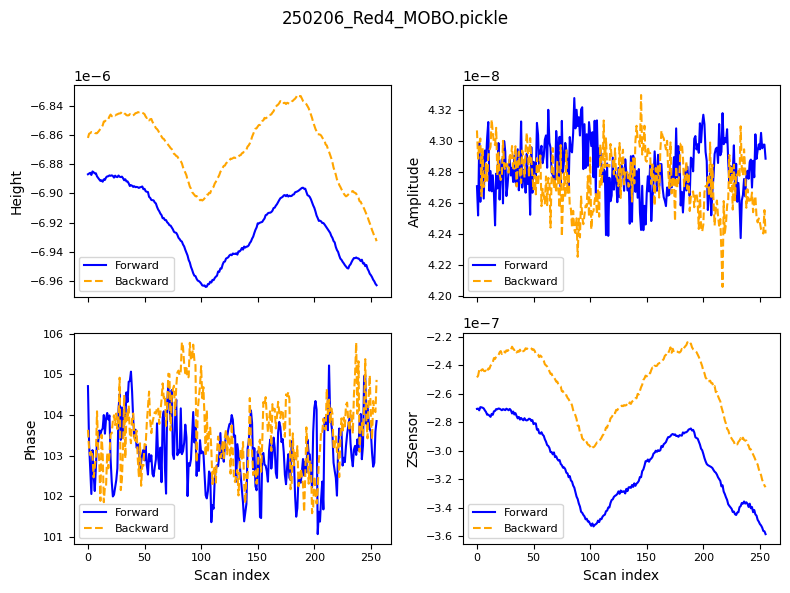

/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/var/folders/93/fpn59tk94sv7p8rsxztxw67m0000gn/T/ipykernel_12849/2936367227.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(fwd)
/var/folders/93/fpn59tk94sv7p8rsxztxw67m0000gn/T/ipykernel_12849/2936367227.py:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kt = kurtosis(fwd)
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


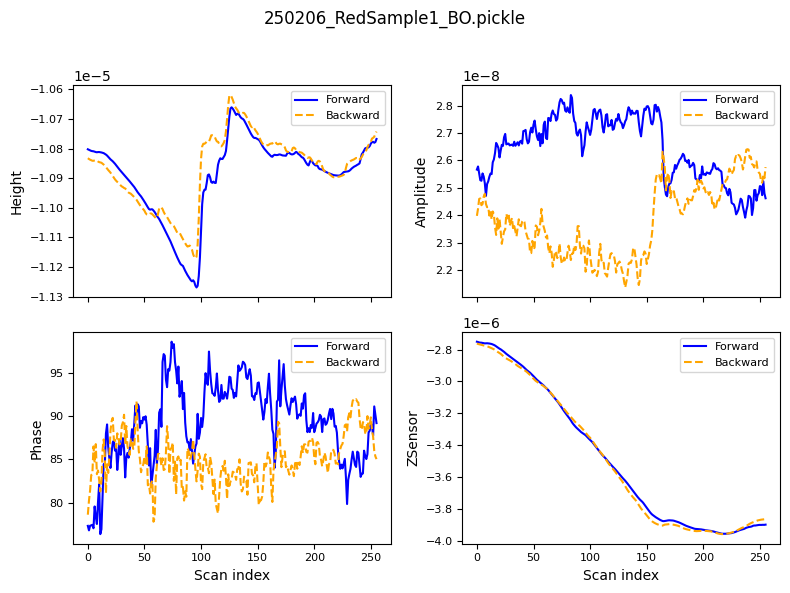

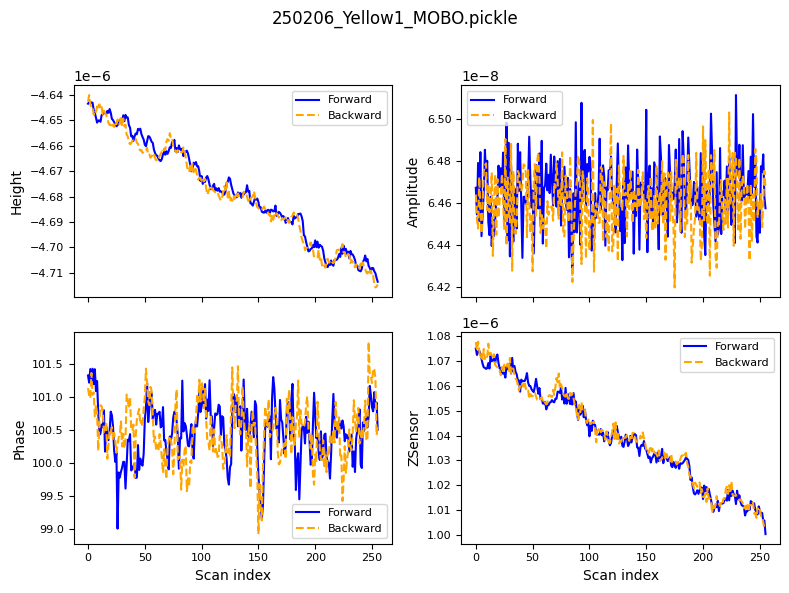

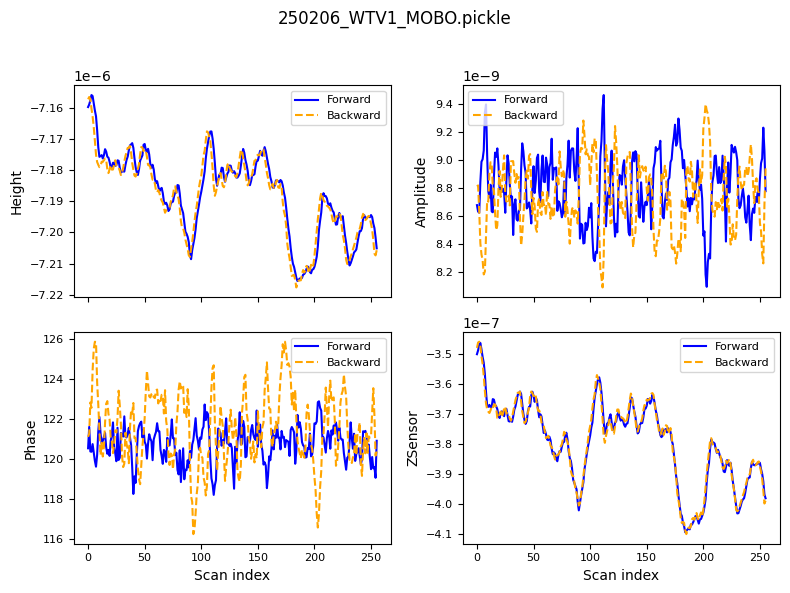

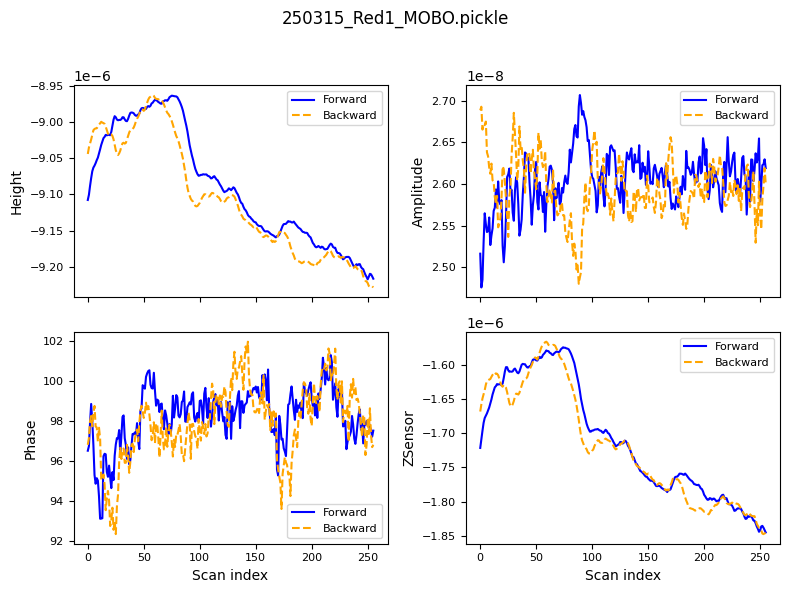

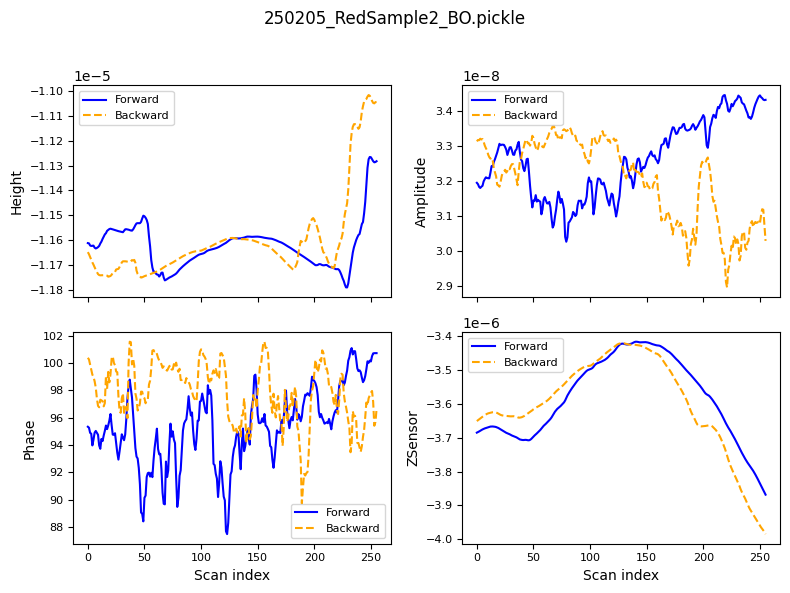

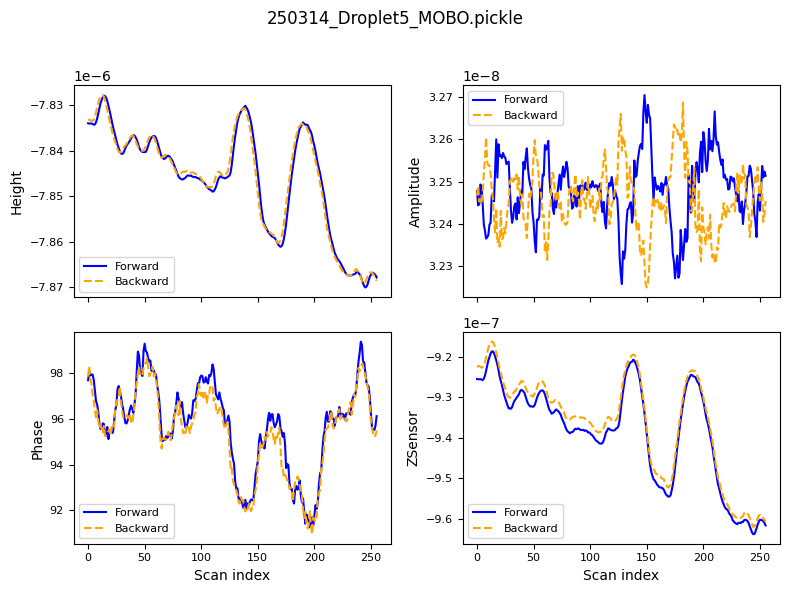

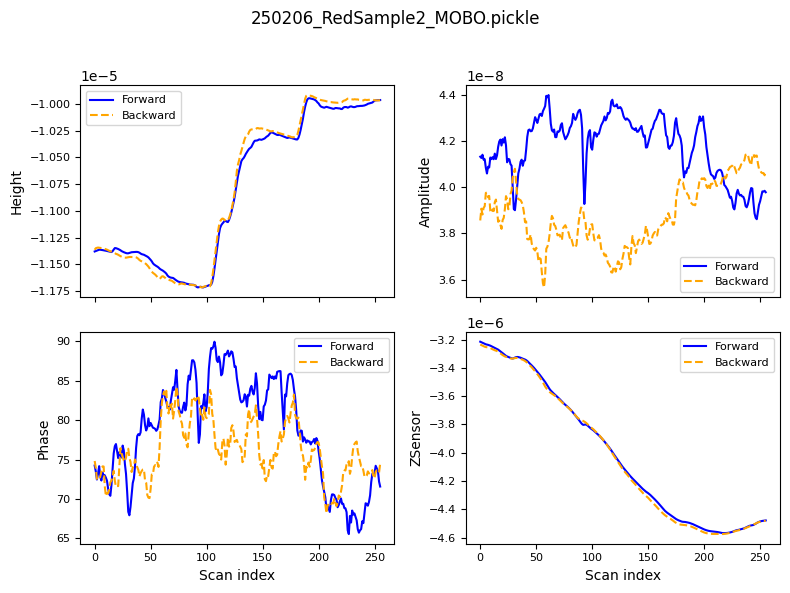

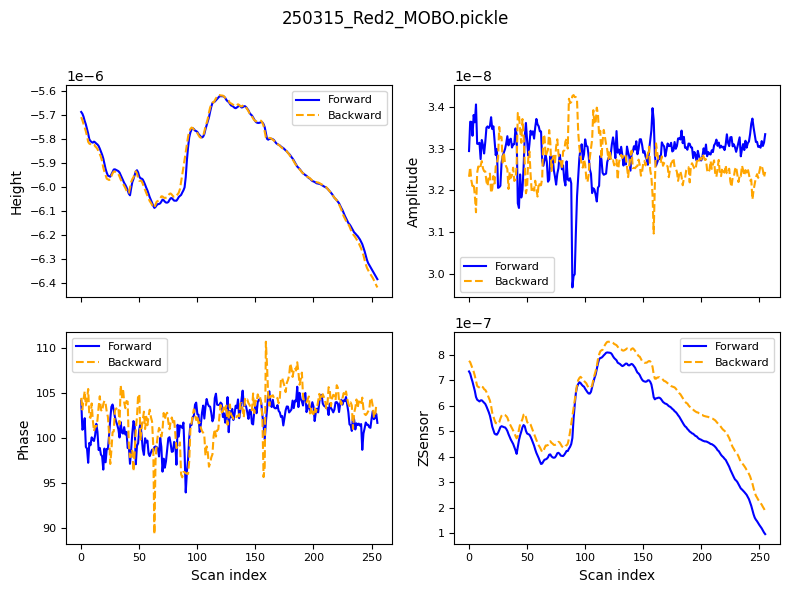

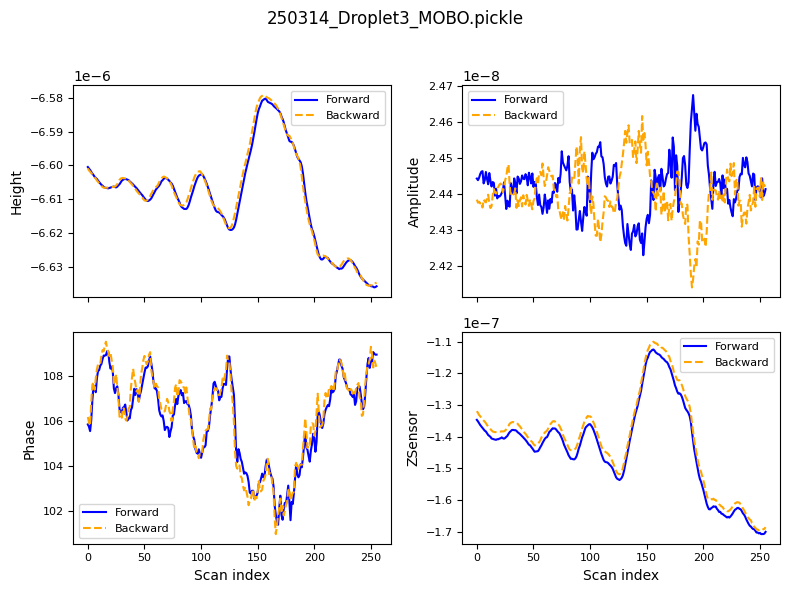

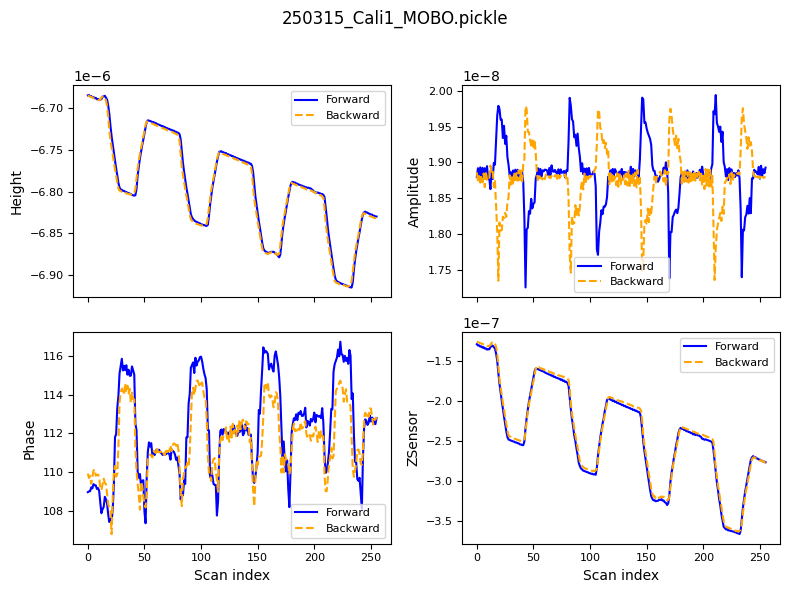

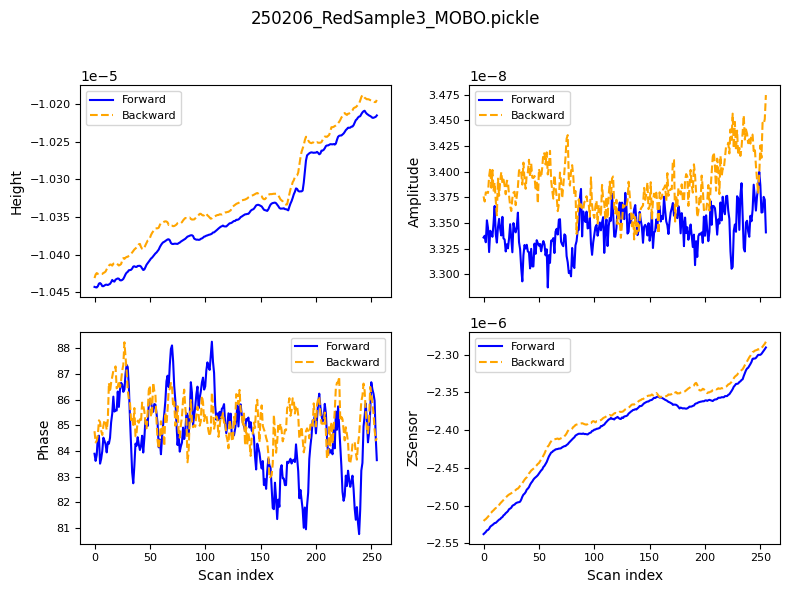

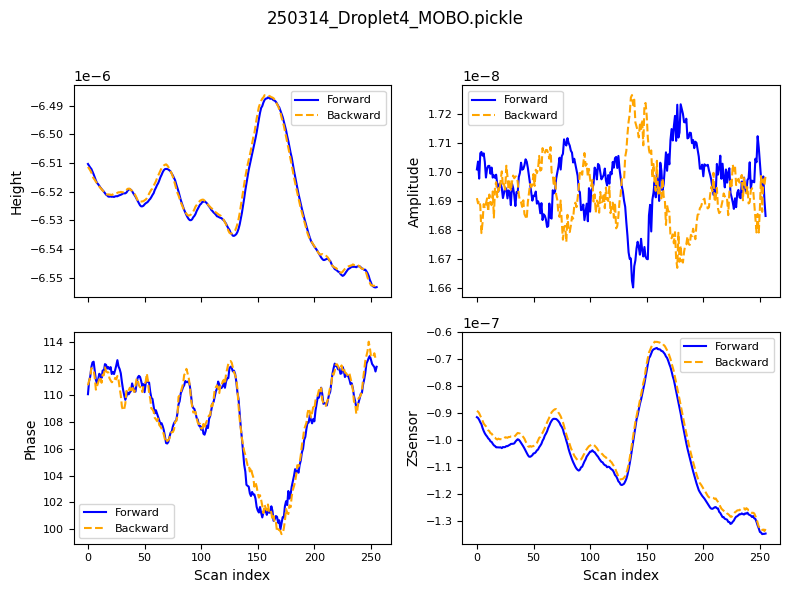

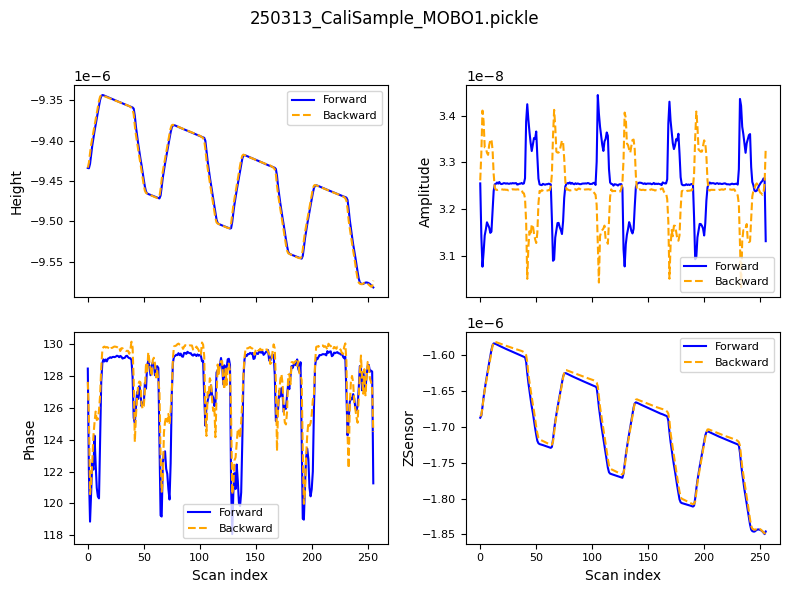

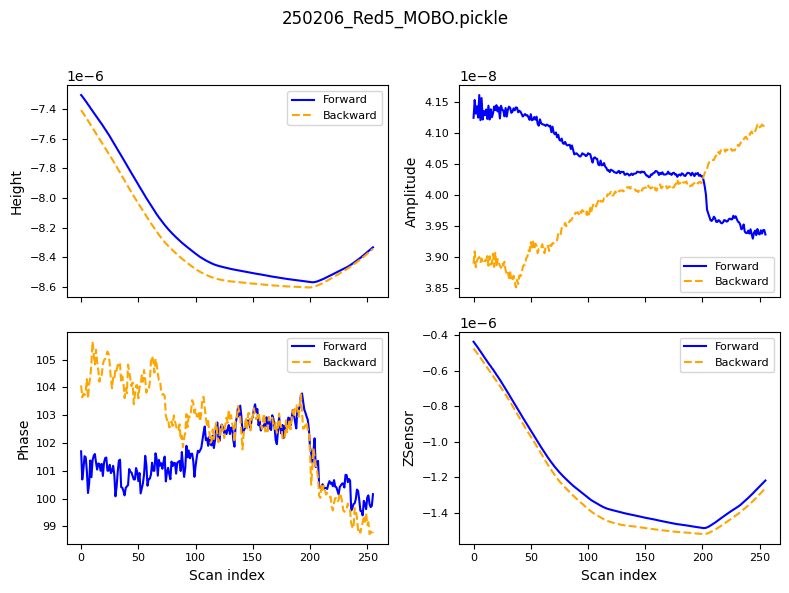

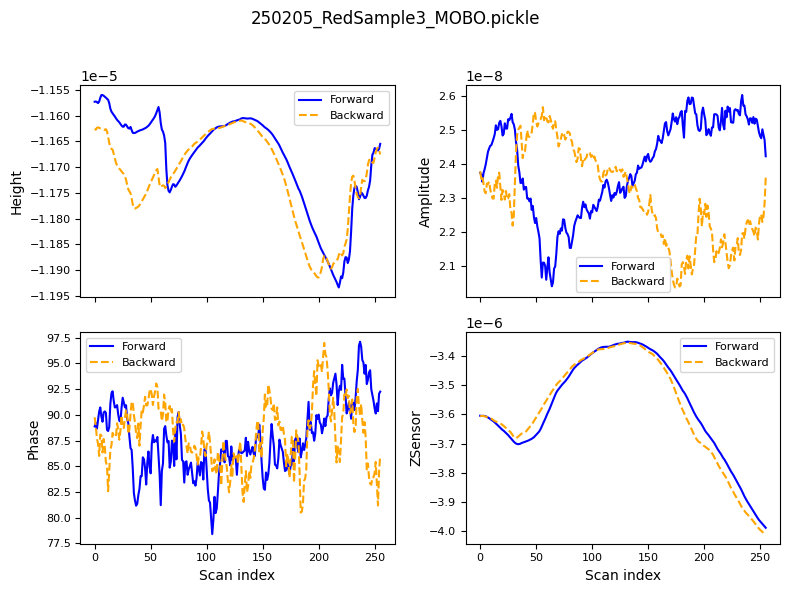

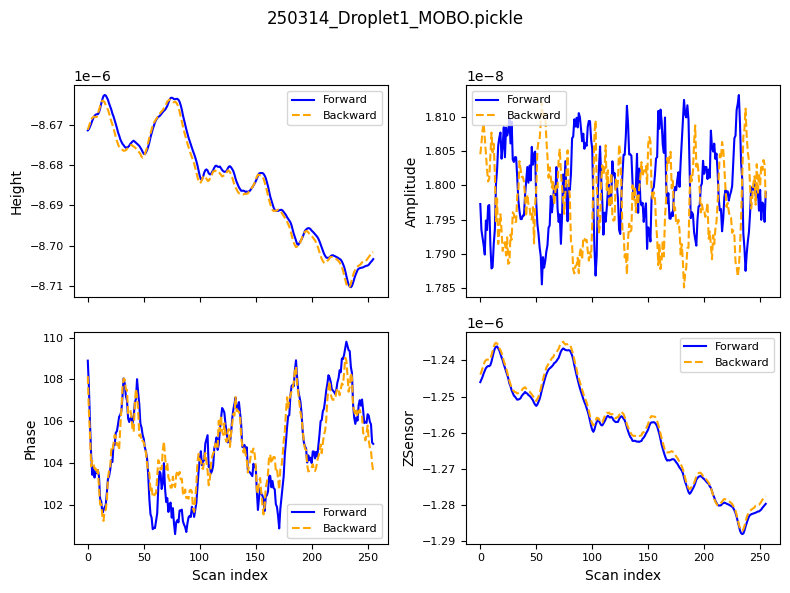

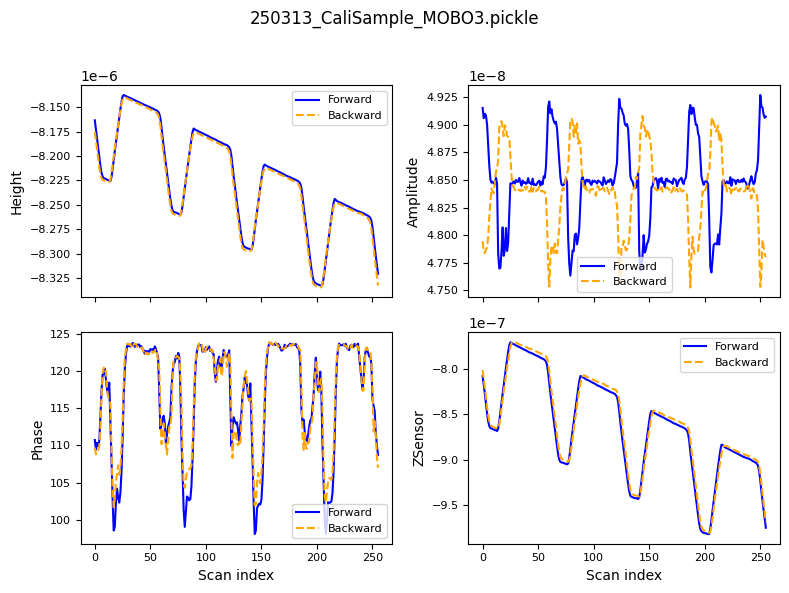

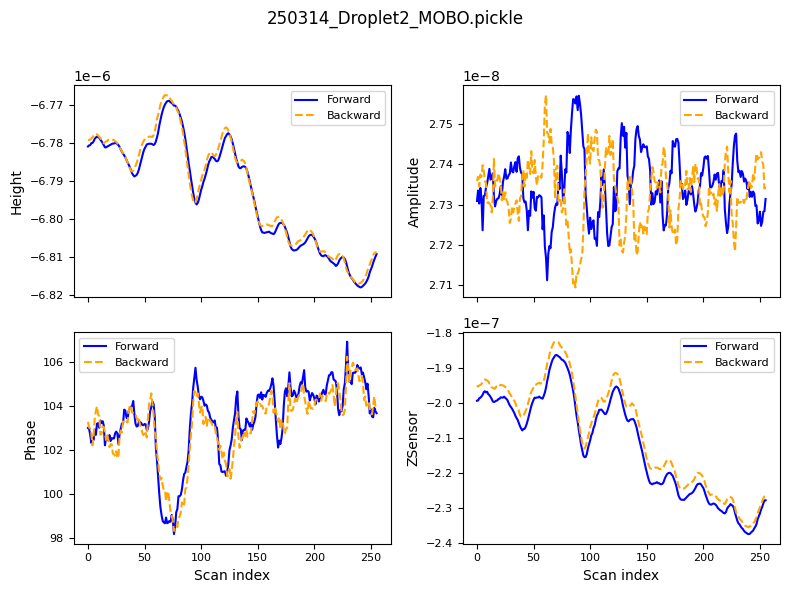

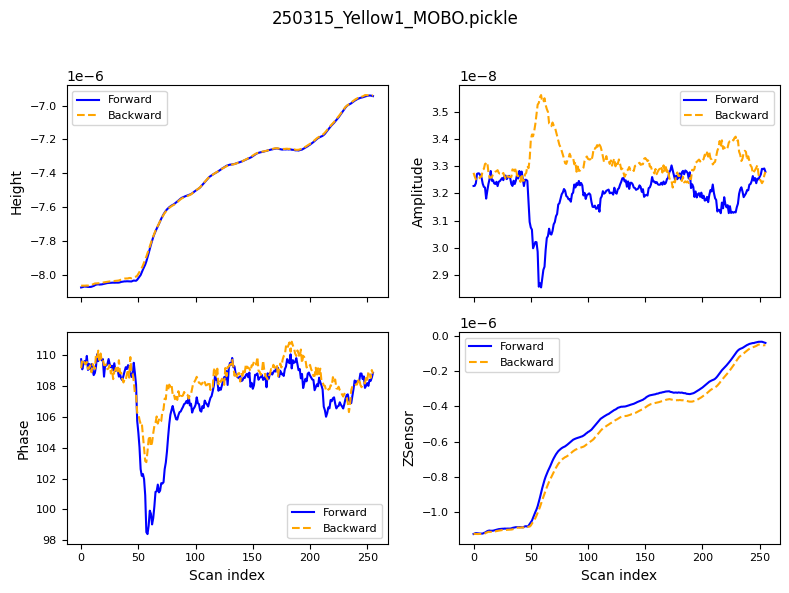

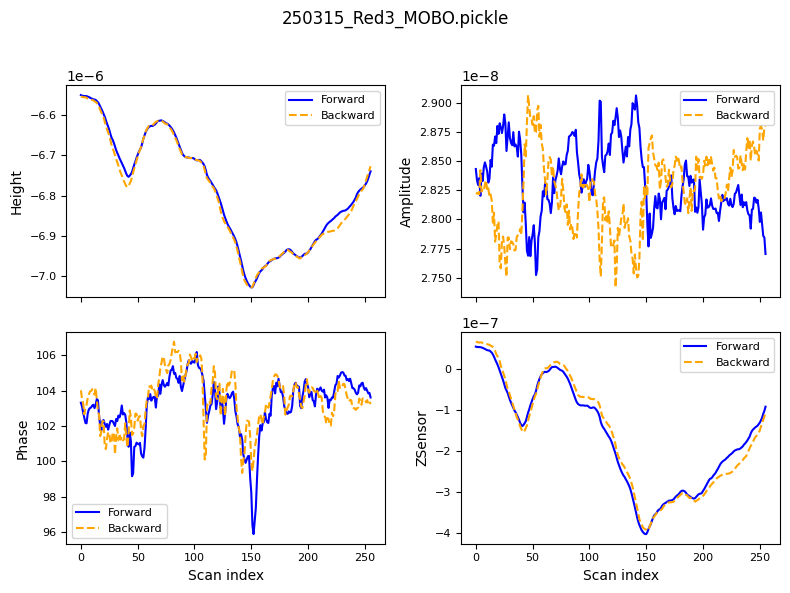

   Height_corr    Height_mae  Height_max_err  Height_std_residual  \
0     0.760664  1.758851e-08    8.223833e-08         2.260140e-08   
1     0.992051  1.796760e-07    2.237233e-07         3.016740e-08   
2     0.988260  3.737178e-09    1.693115e-08         4.897761e-09   
3     0.985575  4.125085e-09    1.799399e-08         5.458226e-09   
4    -0.981794  3.673870e-08    5.324205e-08         1.653229e-08   

   Height_area_diff  Height_entropy  Height_skew  Height_kurtosis  \
0      4.559451e-06        3.305248    -0.838576         1.554011   
1      4.590725e-05        3.651137     0.029493        -1.223250   
2      9.585932e-07        3.439948    -1.058628         1.350082   
3      1.052462e-06        3.441218    -1.031376         1.257641   
4      9.389358e-06        3.455343     0.945075        -0.052028   

   Height_std_fwd  Height_range_fwd  ...  Amplitude_Phase_residual_corr  \
0    3.317910e-08      2.089624e-07  ...                      -0.532620   
1    1.963424e-07   

In [16]:
import os
import pandas as pd

sample_folder = os.path.join('scan_traces', 'MOBO')
files = [os.path.join(sample_folder, f) for f in os.listdir(sample_folder) if f.endswith('.pickle')]
all_features = []

for file_path in files:
    try:
        features = extract_features_from_file(file_path)
        
        if not features: 
            continue

        for feature_set in features:
            if 'Height_mae' not in feature_set:
                print(f"Skipping {file_path}: missing expected keys")
                continue

            all_features.append(feature_set) 

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert to DataFrame for easy handling
df_features = pd.DataFrame(all_features)
print(df_features.head())

In [ ]:
import os
import glob
import pandas as pd

def classify_file(features_list, filename):
    # Average the features over all samples in this file
    df = pd.DataFrame(features_list)
    
    channels = ['Height', 'Amplitude', 'Phase', 'ZSensor']

    # Compute mean MAE and Corr per channel
    mean_mae = {ch: df[f'{ch}_mae'].mean() for ch in channels}
    mean_corr = {ch: df[f'{ch}_corr'].mean() for ch in channels}

    # Define thresholds
    thresholds = {
        'Height': {'mae_max': 2e-8, 'corr_min': 0.7, 'corr_sign': 1},
        'Amplitude': {'corr_min': 0.6, 'corr_sign': -1},
        'Phase': {'corr_min': 0.6, 'corr_sign': 1},
        'ZSensor': {'mae_max': 2e-8, 'corr_min': 0.7, 'corr_sign': 1}
    }

    # Check criteria
    pass_criteria = True

    # Height check
    if mean_mae['Height'] >= thresholds['Height']['mae_max'] or mean_corr['Height'] <= thresholds['Height']['corr_min']:
        pass_criteria = False

    # Amplitude check (only correlation)
    if not (mean_corr['Amplitude'] <= -thresholds['Amplitude']['corr_min']):
        pass_criteria = False

    # Phase check (correlation)
    if mean_corr['Phase'] <= thresholds['Phase']['corr_min']:
        pass_criteria = False

    # ZSensor check
    if mean_mae['ZSensor'] >= thresholds['ZSensor']['mae_max'] or mean_corr['ZSensor'] <= thresholds['ZSensor']['corr_min']:
        pass_criteria = False

    label = 'Good' if pass_criteria else 'Bad'

    # Print summary like your example
    print(f"=== File: {os.path.basename(filename)} ===")
    for ch in channels:
        print(f"{ch:<10} | MAE: {mean_mae[ch]:.3e} | Corr: {mean_corr[ch]:+.3f}")
    print(f"Classification: {label}")
    print()

    return label

# Main loop to go through pickle files
def process_all_pickles(folder_path):
    import pickle

    pickle_files = glob.glob(os.path.join(folder_path, '*.pickle'))
    results = {}

    for file_path in pickle_files:
        try:
            features = extract_features_from_file(file_path)

            if not features:  # Skip empty result (e.g., due to NaNs)
                continue

            # Ensure at least one valid feature set
            if all('Height_mae' not in fs for fs in features):
                print(f"Skipping {file_path}: missing expected keys")
                continue

            label = classify_file(features, file_path)
            results[os.path.basename(file_path)] = label

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return results

import matplotlib.pyplot as plt

In [ ]:
folder = 'scan_traces/MOBO'
classification_results = process_all_pickles(folder)

In [ ]:
def build_dataset(pickle_folder):
    import os
    files = [os.path.join(pickle_folder, f) for f in os.listdir(pickle_folder) if f.endswith('.pickle')]
    X = []
    y = []
    
    for file_path in files:
        try:
            features = extract_features_from_file(file_path)
            if not features:
                continue
            
            label = classify_file(features, file_path)  # returns 'Good' or 'Bad'
            
            # Aggregate features from all feature sets in this file (example: mean per feature)
            df = pd.DataFrame(features)
            mean_features = df.mean().to_dict()
            
            # Add features and label
            X.append(mean_features)
            y.append(1 if label == 'Good' else 0)  # encode Good=1, Bad=0
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    df_X = pd.DataFrame(X)
    return df_X, y

In [ ]:
def train_models_on_features(X, y, models_to_train='all'):
    """
    Train multiple ML models using extracted features from pickle files
    
    Parameters:
    -----------
    X : pandas.DataFrame or numpy.array
        Feature matrix with samples as rows and features as columns
    y : list or numpy.array
        Labels (0 for bad, 1 for good)
    models_to_train : str or list
        'all' to train all models, or list of model names to train
        Available: ['RandomForest', 'XGBoost', 'SVM', 'LogisticRegression', 'GradientBoosting', 'ExtraTrees']
    
    Returns:
    --------
    dict : Dictionary containing trained models and evaluation results
    """
    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score, train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix
    from xgboost import XGBClassifier
    import pickle
    import os
    
    print("=== TRAINING MULTIPLE ML MODELS ON PICKLE FEATURES ===")
    
    # Define available models
    available_models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1),
        'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
        'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    }
    
    # Determine which models to train
    if models_to_train == 'all':
        models_to_use = available_models
    else:
        models_to_use = {name: available_models[name] for name in models_to_train if name in available_models}
    
    print(f"Training models: {list(models_to_use.keys())}")
    
    # Convert to numpy arrays if needed
    if isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
        X = X.values
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Training data: {len(X)} samples, {X.shape[1]} features")
    print(f"Good samples: {sum(y == 1)}, Bad samples: {sum(y == 0)}")
    print(f"Feature names ({len(feature_names)}): {feature_names[:10]}{'...' if len(feature_names) > 10 else ''}")
    
    if len(X) == 0:
        print("No training data available!")
        return None
        
    if len(np.unique(y)) < 2:
        print("ERROR: Need both good and bad samples for training!")
        return None
    
    # Handle NaN values
    if np.isnan(X).any():
        print("Warning: Found NaN values in features. Filling with median values.")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
    
    # Split data once for all models
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale data once
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train all models
    trained_models = {}
    results_summary = []
    
    print(f"\n{'='*60}")
    print("TRAINING AND EVALUATING MODELS")
    print(f"{'='*60}")
    
    for model_name, model in models_to_use.items():
        print(f"\n--- Training {model_name} ---")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        
        # Cross-validation with proper scoring
        try:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
        except:
            # Fallback if AUC fails
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
        
        # Predictions for detailed evaluation
        y_pred = model.predict(X_test_scaled)
        
        print(f"Training accuracy: {train_score:.3f}")
        print(f"Test accuracy: {test_score:.3f}")
        print(f"Cross-validation score: {cv_mean:.3f} (+/- {cv_std * 2:.3f})")
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store results
        results_summary.append({
            'Model': model_name,
            'Train_Accuracy': train_score,
            'Test_Accuracy': test_score,
            'CV_Score_Mean': cv_mean,
            'CV_Score_Std': cv_std
        })
        
        # Create combined model with scaler
        combined_model = ScaledModel(model, scaler)
        trained_models[model_name] = combined_model
        
        # Save individual model in trace_models folder
        filename = f'{model_name}_trace_model.pkl'
        os.makedirs("trace_models", exist_ok=True)
        model_path = os.path.join("trace_models", filename)
        with open(model_path, 'wb') as f:
            pickle.dump(combined_model, f)
        print(f"Model saved as '{model_path}'")
    
    # Results summary
    results_df = pd.DataFrame(results_summary)
    results_df = results_df.sort_values('CV_Score_Mean', ascending=False)
    
    print(f"\n{'='*60}")
    print("MODELS PERFORMANCE SUMMARY (Ranked by CV Score)")
    print(f"{'='*60}")
    print(results_df.to_string(index=False, float_format='%.3f'))
    
    # Feature importance for tree-based models
    print(f"\n{'='*60}")
    print("FEATURE IMPORTANCE (Top 15)")
    print(f"{'='*60}")
    
    for model_name, combined_model in trained_models.items():
        if hasattr(combined_model.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': combined_model.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\n{model_name} - Top 15 Features:")
            print(importance_df.head(15).to_string(index=False, float_format='%.4f'))
    
    # Save results summary
    results_path = os.path.join("trace_models", "training_results.pkl")
    with open(results_path, 'wb') as f:
        pickle.dump({
            'results_summary': results_df,
            'feature_names': feature_names,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'scaler': scaler
        }, f)
    print(f"\nTraining results saved to '{results_path}'")
    
    return {
        'models': trained_models,
        'results_summary': results_df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': feature_names
    }


class ScaledModel:
    """Wrapper class to combine model and scaler"""
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
        
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
        
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)
        
    @property
    def feature_importances_(self):
        if hasattr(self.model, 'feature_importances_'):
            return self.model.feature_importances_
        else:
            return None


def build_dataset_from_pickles(pickle_folder, classify_function):
    """
    Build a dataset from pickle files using the extract_features_from_file function
    
    Parameters:
    -----------
    pickle_folder : str
        Path to folder containing pickle files
    classify_function : function
        Function that takes (features, file_path) and returns 'Good' or 'Bad'
    
    Returns:
    --------
    tuple : (X_df, y) where X_df is feature DataFrame and y is list of labels
    """
    import os
    import pandas as pd
    
    files = [os.path.join(pickle_folder, f) for f in os.listdir(pickle_folder) if f.endswith('.pickle')]
    
    X = []
    y = []
    failed_files = []
    
    print(f"Processing {len(files)} pickle files...")
    
    for i, file_path in enumerate(files):
        try:
            print(f"Processing file {i+1}/{len(files)}: {os.path.basename(file_path)}")
            
            # Extract features using your function
            features_list = extract_features_from_file(file_path)
            
            if not features_list:
                print(f"  No features extracted from {os.path.basename(file_path)}")
                continue
            
            # Get classification for this file
            label = classify_function(features_list, file_path)  # returns 'Good' or 'Bad'
            
            # Aggregate features from all feature sets in this file (mean per feature)
            df_features = pd.DataFrame(features_list)
            mean_features = df_features.mean().to_dict()
            
            # Add features and label
            X.append(mean_features)
            y.append(1 if label == 'Good' else 0)  # encode Good=1, Bad=0
            
            print(f"  Successfully processed: {label} ({len(features_list)} feature sets)")
            
        except Exception as e:
            print(f"  Error processing {os.path.basename(file_path)}: {e}")
            failed_files.append(file_path)
    
    if failed_files:
        print(f"\nFailed to process {len(failed_files)} files:")
        for f in failed_files:
            print(f"  {os.path.basename(f)}")
    
    # Convert to DataFrame
    X_df = pd.DataFrame(X)
    
    print(f"\nDataset built:")
    print(f"  Total samples: {len(X_df)}")
    print(f"  Good samples: {sum(y)}")
    print(f"  Bad samples: {len(y) - sum(y)}")
    print(f"  Features: {len(X_df.columns)}")
    
    return X_df, y


# Helper functions for easy use
def train_all_trace_models(X, y):
    """Train all available models on trace features"""
    return train_models_on_features(X, y, models_to_train='all')

def train_specific_trace_models(X, y, model_list):
    """Train specific models on trace features"""
    return train_models_on_features(X, y, models_to_train=model_list)

def load_trace_model(model_name):
    """Load a saved trace model"""
    model_path = os.path.join("trace_models", f'{model_name}_trace_model.pkl')
    with open(model_path, 'rb') as f:
        return pickle.load(f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns

def evaluate_model_auc_roc(model, X_test, y_test, model_name="Model", plot=True):
    """
    Evaluate a binary classification model using AUC-ROC metrics
    
    Parameters:
    -----------
    model : trained model object
        Must have predict_proba method
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    model_name : str
        Name for the model (used in plots)
    plot : bool
        Whether to generate ROC curve plot
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    
    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    else:
        raise ValueError("Model must have predict_proba method for AUC-ROC calculation")
    
    # Get binary predictions
    y_pred = model.predict(X_test)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Alternative AUC calculation (should be the same)
    roc_auc_sklearn = roc_auc_score(y_test, y_proba)
    
    # Print results
    print(f"=== {model_name} AUC-ROC Evaluation ===")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    print(f"AUC-ROC (sklearn): {roc_auc_sklearn:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    if plot:
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # ROC Curve
        ax1.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'{model_name} - ROC Curve')
        ax1.legend(loc="lower right")
        ax1.grid(True, alpha=0.3)
        
        # Confusion Matrix Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title(f'{model_name} - Confusion Matrix')
        ax2.set_ylabel('True Label')
        ax2.set_xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()
    
    # Return metrics dictionary
    return {
        'auc_roc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

def cross_validate_auc_roc(model, X, y, cv_folds=5, model_name="Model"):
    """
    Perform cross-validation with AUC-ROC scoring
    
    Parameters:
    -----------
    model : sklearn model object
        Untrained model
    X : array-like
        Features
    y : array-like
        Labels
    cv_folds : int
        Number of cross-validation folds
    model_name : str
        Name for the model
    
    Returns:
    --------
    dict : Cross-validation results
    """
    
    print(f"=== {model_name} Cross-Validation AUC-ROC ===")
    
    # Stratified K-Fold to maintain class balance
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Cross-validation with AUC scoring
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    
    print(f"Cross-Validation AUC-ROC Scores: {cv_scores}")
    print(f"Mean AUC-ROC: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    print(f"95% Confidence Interval: {cv_scores.mean():.4f} ± {1.96 * cv_scores.std():.4f}")
    
    return {
        'cv_scores': cv_scores,
        'mean_auc': cv_scores.mean(),
        'std_auc': cv_scores.std()
    }

def load_and_evaluate_pickled_model(model_path, X_test, y_test, model_name="Pickled Model"):
    """
    Load a pickled model and evaluate it with AUC-ROC
    
    Parameters:
    -----------
    model_path : str
        Path to the pickled model file
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    model_name : str
        Name for the model
    
    Returns:
    --------
    dict : Evaluation results
    """
    
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        
        print(f"Successfully loaded model from {model_path}")
        
        # Evaluate the model
        results = evaluate_model_auc_roc(model, X_test, y_test, model_name)
        
        return results
        
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

def benchmark_multiple_models(models_dict, X_test, y_test, plot_comparison=True):
    """
    Compare multiple models using AUC-ROC
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model_name: model_object pairs
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    plot_comparison : bool
        Whether to create comparison plot
    
    Returns:
    --------
    dict : Results for all models
    """
    
    results = {}
    
    if plot_comparison:
        plt.figure(figsize=(10, 8))
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*50}")
        result = evaluate_model_auc_roc(model, X_test, y_test, model_name, plot=False)
        results[model_name] = result
        
        if plot_comparison:
            plt.plot(result['fpr'], result['tpr'], lw=2, 
                    label=f'{model_name} (AUC = {result["auc_roc"]:.4f})')
    
    if plot_comparison:
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Summary table
    print(f"\n{'='*50}")
    print("SUMMARY - AUC-ROC Comparison")
    print(f"{'='*50}")
    for model_name, result in results.items():
        print(f"{model_name:20s}: AUC = {result['auc_roc']:.4f}")
    
    return results

# Example usage functions
def example_with_trained_model(trained_model, X_test, y_test):
    return evaluate_model_auc_roc(trained_model, X_test, y_test, "RandomForest")

def example_with_pickled_model(X_test, y_test):
    return load_and_evaluate_pickled_model('RandomForest_model.pkl', X_test, y_test, "RandomForest")

def example_cross_validation(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    return cross_validate_auc_roc(model, X_train, y_train, cv_folds=5, model_name="RandomForest")

# Interpretation guide
def interpret_auc_roc_score(auc_score):
    """
    Provide interpretation of AUC-ROC score
    """
    print(f"\n=== AUC-ROC Score Interpretation ===")
    print(f"Your AUC-ROC Score: {auc_score:.4f}")
    
    if auc_score >= 0.9:
        interpretation = "Excellent"
    elif auc_score >= 0.8:
        interpretation = "Good"
    elif auc_score >= 0.7:
        interpretation = "Fair"
    elif auc_score >= 0.6:
        interpretation = "Poor"
    else:
        interpretation = "Very Poor (worse than random)"
    
    print(f"Interpretation: {interpretation}")
    print(f"""
    AUC-ROC Interpretation Guide:
    - 1.0: Perfect classifier
    - 0.9-1.0: Excellent
    - 0.8-0.9: Good  
    - 0.7-0.8: Fair
    - 0.6-0.7: Poor
    - 0.5-0.6: Very Poor
    - 0.5: Random classifier (no discriminative ability)
    - <0.5: Worse than random (but can be inverted)
    """)

In [ ]:
# Build dataset from pickle files
X_df, y = build_dataset_from_pickles('scan_traces/MOBO', classify_file)

# Train all models
results = train_all_trace_models(X_df, y)

# # Or train specific models
# results = train_specific_trace_models(X_df, y, ['RandomForest', 'XGBoost'])

# # Load a saved model later
# model = load_trace_model('RandomForest')
# predictions = model.predict(new_features)

if results is not None:
    auc_results = benchmark_multiple_models(
        results['models'],     # Dictionary of all trained models
        results['X_test'],     # Test features
        results['y_test'],     # Test labels
        plot_comparison=True   # Creates comparison ROC plot
    )
else:
    print("Model training failed: not enough data or only one class present in labels.")



In [ ]:
import numpy as np
import pandas as pd
import pickle
import joblib

def predict_file_class(pickle_path, model_path):
    """
    Predict classification for a pickle file using a trained model
    
    Parameters:
    -----------
    pickle_path : str
        Path to the pickle file to classify
    model_path : str
        Path to the saved ScaledModel (.pkl file)
    
    Returns:
    --------
    tuple : (label, confidence) where label is 0/1 and confidence is the probability
    """
    
    # Load the ScaledModel
    with open(model_path, 'rb') as f:
        scaled_model = pickle.load(f)
    
    # Extract features from the file
    feature_dicts = extract_features_from_file(pickle_path)
    if not feature_dicts:
        raise ValueError("No features extracted from file.")
    
    # Convert to DataFrame and average across all entries (if multiple)
    df = pd.DataFrame(feature_dicts)
    mean_features = df.mean(numeric_only=True)
    
    print(f"Extracted {len(mean_features)} features from file")
    print(f"Available features: {list(mean_features.index)}")
    
    # Check if the underlying model has feature_names_in_ (scikit-learn 1.0+)
    underlying_model = scaled_model.model
    
    if hasattr(underlying_model, 'feature_names_in_'):
        expected_features = underlying_model.feature_names_in_
        print(f"Model expects {len(expected_features)} features: {list(expected_features)}")
        
        # Reindex to match expected feature order, fill missing with 0
        X = mean_features.reindex(expected_features).fillna(0.0).values.reshape(1, -1)
        
        # Check for missing features
        missing_features = set(expected_features) - set(mean_features.index)
        if missing_features:
            print(f"Warning: Missing features filled with 0.0: {missing_features}")
            
    elif hasattr(underlying_model, 'n_features_in_'):
        expected_n_features = underlying_model.n_features_in_
        print(f"Model expects {expected_n_features} features (no feature names available)")
        
        X = mean_features.values.reshape(1, -1)
        if X.shape[1] != expected_n_features:
            if X.shape[1] < expected_n_features:
                # Pad with zeros if we have fewer features
                padding = np.zeros((1, expected_n_features - X.shape[1]))
                X = np.concatenate([X, padding], axis=1)
                print(f"Warning: Padded {expected_n_features - mean_features.shape[0]} features with 0.0")
            else:
                # Truncate if we have more features
                X = X[:, :expected_n_features]
                print(f"Warning: Truncated to first {expected_n_features} features")
    else:
        # Fallback: use all available features
        print("Warning: Cannot determine expected feature count from model")
        X = mean_features.values.reshape(1, -1)
    
    print(f"Final feature vector shape: {X.shape}")
    
    # Use the ScaledModel's predict method (it handles scaling internally)
    label = scaled_model.predict(X)[0]
    
    # Get confidence if available
    confidence = None
    if hasattr(scaled_model, 'predict_proba'):
        try:
            proba = scaled_model.predict_proba(X)[0]
            confidence = proba.max()
        except:
            print("Warning: Could not get prediction probabilities")
    
    return int(label), confidence


def predict_file_class_verbose(pickle_path, model_path):
    """
    Verbose version that shows detailed information about features and predictions
    """
    try:
        label, confidence = predict_file_class(pickle_path, model_path)
        
        # Interpret results
        class_name = "Good" if label == 1 else "Bad"
        confidence_str = f"{confidence:.3f}" if confidence is not None else "N/A"
        
        print(f"\n=== PREDICTION RESULTS ===")
        print(f"File: {pickle_path}")
        print(f"Prediction: {class_name} (label={label})")
        print(f"Confidence: {confidence_str}")
        
        return label, confidence
        
    except Exception as e:
        print(f"Error predicting file class: {e}")
        return None, None


def batch_predict_files(pickle_folder, model_path, file_pattern="*.pickle"):
    """
    Predict classifications for multiple files in a folder
    """
    import glob
    import os
    
    pattern = os.path.join(pickle_folder, file_pattern)
    files = glob.glob(pattern)
    
    if not files:
        print(f"No files found matching pattern: {pattern}")
        return []
    
    results = []
    print(f"Processing {len(files)} files...")
    
    for i, file_path in enumerate(files):
        print(f"\n--- File {i+1}/{len(files)}: {os.path.basename(file_path)} ---")
        
        try:
            label, confidence = predict_file_class(file_path, model_path)
            class_name = "Good" if label == 1 else "Bad"
            
            result = {
                'file': os.path.basename(file_path),
                'path': file_path,
                'prediction': class_name,
                'label': label,
                'confidence': confidence
            }
            results.append(result)
            
            conf_str = f" (conf: {confidence:.3f})" if confidence else ""
            print(f"Result: {class_name}{conf_str}")
            
        except Exception as e:
            print(f"Error: {e}")
            result = {
                'file': os.path.basename(file_path),
                'path': file_path,
                'prediction': 'ERROR',
                'label': None,
                'confidence': None,
                'error': str(e)
            }
            results.append(result)
    
    # Summary
    successful = [r for r in results if r['prediction'] != 'ERROR']
    if successful:
        good_count = sum(1 for r in successful if r['label'] == 1)
        bad_count = len(successful) - good_count
        
        print(f"\n=== BATCH PREDICTION SUMMARY ===")
        print(f"Total files processed: {len(files)}")
        print(f"Successful predictions: {len(successful)}")
        print(f"Good predictions: {good_count}")
        print(f"Bad predictions: {bad_count}")
        print(f"Errors: {len(results) - len(successful)}")
    
    return results

In [ ]:
# Simple prediction
label, confidence = predict_file_class(
    pickle_path="scan_traces/MOBO/250314_Droplet5_MOBO.pickle",
    model_path="trace_models/RandomForest_trace_model.pkl"
)
print(f"Prediction: {'Good' if label == 1 else 'Bad'} (confidence: {confidence:.3f})")

# # Verbose prediction with detailed output
# predict_file_class_verbose(
#     pickle_path="scan_traces/MOBO/250206_Red4_MOBO.pickle",
#     model_path="trace_models/RandomForest_trace_model.pkl"
# )

# # Batch processing
# results = batch_predict_files(
#     pickle_folder="scan_traces/MOBO/",
#     model_path="trace_models/RandomForest_trace_model.pkl"
# )